# MIE 1624 - Assignment 2 - Winter 2019 - Ramin Mardani

In [1]:
#Importing libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
%matplotlib inline 
warnings.filterwarnings("ignore")

#Importing all the required ML packages
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor 
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.decomposition import PCA

#  Part 1: Data Cleaning

In [2]:
#import "kaggle_salary.csv" file as a dataframe
df = pd.read_csv("kaggle_salary.csv", low_memory = False)
df=df.iloc[1:].reset_index(drop=True)
df.shape

(15429, 397)

The following plot can show us the distribution of missing values in our dataframe.

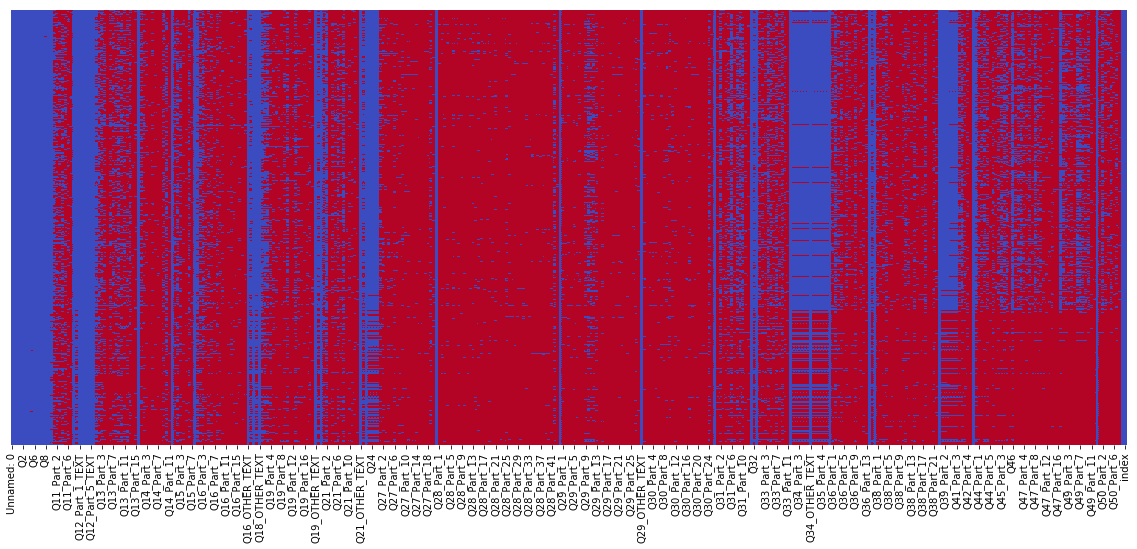

In [3]:
fig, ax = plt.subplots(figsize=(20,8))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

First, it would be better to remove columns which can not provide any special information.
There are some columns with the name of "OTHER_TEXT" and they are just reference numbers and we can remove them without any bad effect on database.

In [4]:
# We can see in Q7_OTHER_TEXT the column has some reference number - drop this column
df.drop(['Q1_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q6_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q7_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q42_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q49_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q50_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q12_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q11_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q13_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q14_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q15_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q16_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q17_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q31_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q33_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q34_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q38_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q35_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q36_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q37_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q20_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q18_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q19_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q21_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q22_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q27_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q28_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q29_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q30_OTHER_TEXT'], axis=1, inplace=True)
df.drop(['Q12_Part_5_TEXT'], axis=1, inplace=True)
df.drop(['Q12_Part_4_TEXT'], axis=1, inplace=True)
df.drop(['Q12_Part_3_TEXT'], axis=1, inplace=True)
df.drop(['Q12_Part_2_TEXT'], axis=1, inplace=True)
df.drop(['Q12_Part_1_TEXT'], axis=1, inplace=True)
df.drop(['Q32_OTHER'], axis=1, inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.drop(df.columns[0], axis=1, inplace=True)

Our database is about a survey which is conducted and every row is the information of each participant. Some of participant didn't complete all parts and in some columns are lots of missing values. We can remove the columns that their length is lower than a threshold with this code:

In [5]:
df = df.dropna(thresh=len(df) - 10000, axis=1) #drop columns with too many NAs
df.shape

(15429, 69)

There is a column in our database about time to finish the survey. It will be logical to remove the rows which participants onsidered less than 2 minutes for answering questions. By this method, we can remove nearly 300 rows which is expected to have many missing values.

In [6]:
df['Time from Start to Finish (seconds)'] = df['Time from Start to Finish (seconds)'].apply(float)
df = df[df['Time from Start to Finish (seconds)']>120]
df.shape

(15144, 69)

There are 4 cases in our database that the participant is student and selected amount for the compensation is more than 500,000$. This 4 cases can not be reliable and it would be better to remove them.

In [7]:
df.drop(df.loc[(df['Q9'].astype(float) >= 500000) & (df['Q6']=='Student')].index, inplace=True)

There are about 3,000 rows of data that have lots of missing values. By defining a threshold, we can remove them because it would be better not to have the cases with lots of missing values.

In [8]:
df=df.dropna(axis=0, how='any', thresh=30, subset=None, inplace=False)
df.shape

(12244, 69)

Until now, we droped features and rows that were not discrenable or valid enough. Let's see how many missing values remained in each column of our database:

In [9]:
df.isnull().sum(axis=0)

Time from Start to Finish (seconds)       0
Q1                                        0
Q2                                        0
Q3                                        0
Q4                                        0
Q5                                       70
Q6                                        0
Q7                                        0
Q8                                       54
Q9                                        0
Q10                                       0
Q11_Part_1                             5590
Q11_Part_4                             7009
Q12_MULTIPLE_CHOICE                       0
Q13_Part_1                             2760
Q13_Part_2                             6293
Q13_Part_9                             7082
Q14_Part_10                            7528
Q15_Part_2                             6841
Q16_Part_1                             1775
Q16_Part_3                             6489
Q17                                    2047
Q18                             

From this part, we will fill the missing values with something tangible instead of removing features or rows.

In column of Q8, it is asked from participants about How years of experience in their current role. Some paticipants were students and didn't answer this question. As far as most of studens are in touch with special topic for a short term and there is a difference between what they do in school and in their job, it would be better the consider them to have 0-1 years of expericence.

In [10]:
df.loc[(df['Q7'] == 'I am a student') & (df['Q8'].isna()), 'Q8'] = '0-1'

In column of Q23, it is asked from participants about percentage of time which they consider for coding. In case there is no response from participants in this column, we can fill some of the missing values with mode of that column. If there is a missing value in column "Q23" and the participant is 'student', it is logical to fill the missing values with mean value of that column for students becasue students usually consider similar amount of time for coding during each semester.
Moreover, we can substitute values for participants who are not student with the mode for the time which non-student participants consider for coding because majority of people who their profession is coding, they consider a quite similar amount of time for coding.

In [11]:
df1=df.loc[(df['Q6'] == 'Student')]
df.loc[ (df['Q23'].isna()) &(df['Q6']=='Student') , 'Q23'] = df1['Q23'].mode()[0]

df2=df.loc[(df['Q6'] != 'Student')]
df.loc[ (df['Q23'].isna()) &(df['Q6']!='Student') , 'Q23'] = df2['Q23'].mode()[0]

In column Q24, it is asked from participants about the time period which which they consider for analyzing data with writing code. we did a similar procedure of Q23 for this column. If participants are student, they usually have considered similar time for analyzing data. Also if they are not students, it will expected they will consider similar time for analyzing data.

In [12]:
df1=df.loc[(df['Q6'] == 'Student')]
df.loc[ (df['Q24'].isna()) &(df['Q6']=='Student') , 'Q24'] = df1['Q24'].mode()[0]

df2=df.loc[(df['Q6'] != 'Student')]
df.loc[ (df['Q24'].isna()) &(df['Q6']!='Student') , 'Q24'] = df2['Q24'].mode()[0]

We can use the method for Q23 and Q24 in Q25 and Q26.

In [13]:
df1=df.loc[(df['Q6'] == 'Student')]
df.loc[ (df['Q25'].isna()) &(df['Q6']=='Student') , 'Q25'] = df1['Q25'].mode()[0]

df2=df.loc[(df['Q6'] != 'Student')]
df.loc[ (df['Q25'].isna()) &(df['Q6']!='Student') , 'Q25'] = df2['Q25'].mode()[0]

df1=df.loc[(df['Q6'] == 'Student')]
df.loc[ (df['Q26'].isna()) &(df['Q6']=='Student') , 'Q26'] = df1['Q26'].mode()[0]

df2=df.loc[(df['Q6'] != 'Student')]
df.loc[ (df['Q26'].isna()) &(df['Q6']!='Student') , 'Q26'] = df2['Q26'].mode()[0]

Finally, we will fill other missing values with N/A.

In [14]:
df.fillna("N/A", inplace=True) 

This graph can show us that theire is no missing value in out database anymore.

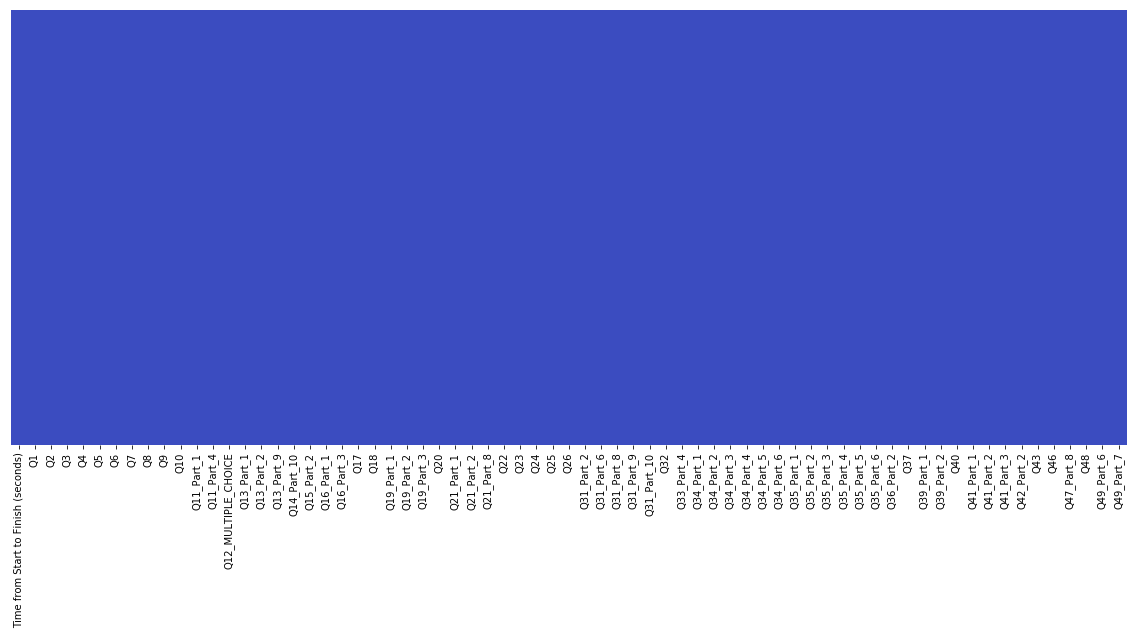

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

In some columns of our database, some choices which is made by survey designers can lead to decrease in our data analyzing quality. Thus, we will try to prepare our data in a way to achieve better results.
For example in Q1, which participants should assign their gender, there are 4 ununique category. By decreasing these categories to 3, we can have better categorization for predicting salary.

In [16]:
df6=df.copy()
df.loc[ (df['Q1']=='Prefer not to say'), 'Q1'] = 'Other'
df.loc[ (df['Q1']=='Prefer to self-describe') , 'Q1'] = 'Other'

For Q5, becasue of not having a suitable choices, some participants did not answer the question. They declared on Q4 that they did not have a formal education past highschool and we asked them again about their major in university. Thus, it would be better to change the N/A values of people with no formal education pas high school in Q5 with "I never declared a major'.

In [17]:
df.loc[ (df['Q4']=='No formal education past high school') & (df['Q5']=='N/A'),'Q5']='I never declared a major'

In Q8, it is asked about years of experience. There are some participants that they declared on Q7 that they are students but they did not assign that. Moreover, there are some similar cases that the paricipants is student and his\her employer is Academics or education but they didn't assign that they have no or less than 1 year experience.

In [18]:
df.loc[ (df['Q6']=='Student') & (df['Q7']=='Academics/Education') & (df['Q8']=='N/A'),'Q8']= '0-1'
df.loc[ (df['Q7']=='I am a student')  & (df['Q8']=='N/A'),'Q8']= 'I am a student'

In Q10, there are some students who declared that they are student but they didn't choose "I am a student" which was a category in Q10.

In [19]:
df.loc[ (df['Q6']=='Student') & (df['Q10']=='I do not know'),'Q10']='I am a student'

In Q24, there are 2 categories of 'I have never written code and I do not want to learn' and 'I have never written code but I want to learn'. These categories deliver the same message if our goal is to estimate yearly compensation. Thus, we can combine these two categoy in one.

Something similar to Q24 can be used for Q25 and we can combine 2 categories in one.

In [20]:
df.loc[ (df['Q24']=='I have never written code and I do not want to learn'),'Q24']='I have never written code'
df.loc[ (df['Q24']=='I have never written code but I want to learn'),'Q24']='I have never written code'

df.loc[ (df['Q25']=='I have never studied machine learning but plan to learn in the future'),'Q25']='I have never studied machine learning'
df.loc[ (df['Q25']=='I have never studied machine learning and I do not plan to'),'Q25']='I have never studied machine learning'

There are some columns which there is a default category of 'No opinion; I do not know' and it would be better to change "N/A" to this category.

In [21]:
df.loc[ (df['Q39_Part_1']=='N/A'),'Q39_Part_1']='No opinion; I do not know'
df.loc[ (df['Q39_Part_2']=='N/A'),'Q39_Part_2']='No opinion; I do not know'
df.loc[ (df['Q40']=='N/A'),'Q40']='No opinion; I do not know'
df.loc[ (df['Q41_Part_1']=='N/A'),'Q41_Part_1']='No opinion; I do not know'
df.loc[ (df['Q41_Part_2']=='N/A'),'Q41_Part_2']='No opinion; I do not know'
df.loc[ (df['Q41_Part_3']=='N/A'),'Q41_Part_3']='No opinion; I do not know'
df.loc[ (df['Q48']=='N/A'),'Q48']='I do not know; I have no opinion on the matter'

## Data Encoding

What we have in our database is so many categorical data and they need to converted into numerical values since sklearn only takes numerical values as input in a numpy array.

There are three types of categorical data in general: nominal, ordinal, and continous.

what we have in our data base is a mix of nominal and ordinal values. For nominal values, the best way is to use dummy variables. In this method, all of unique categorical data will make new columns and each columns will include numbers between 0 and 1. If we have a category in one of rows, it will define as 1 and otherwise, it would be zero.

for ordinal data which there is an order between each category it would be better to not use dummy variables. We can encode our ordinal categorised data will sklearn labelencoder or encoding the data based on their order manually.

In this project, we will use dummy variables and manual coding for encoding our data.

First of all, we will define our target value which is Q9 in our database and other columns of our database.

In [22]:
y=df['Q9']
x=df.drop(['Q9'], axis=1)
x.shape

(12244, 68)

In this part, we will see how many categories are in our columns of database:

In [23]:
x.nunique()

Time from Start to Finish (seconds)    4502
Q1                                        3
Q2                                       12
Q3                                       58
Q4                                        7
Q5                                       13
Q6                                       20
Q7                                       19
Q8                                       12
Q10                                       7
Q11_Part_1                                2
Q11_Part_4                                2
Q12_MULTIPLE_CHOICE                       6
Q13_Part_1                                2
Q13_Part_2                                2
Q13_Part_9                                2
Q14_Part_10                               2
Q15_Part_2                                2
Q16_Part_1                                2
Q16_Part_3                                2
Q17                                      18
Q18                                      13
Q19_Part_1                      

As we see, there are some columns that have many ununique categories. Due to this reason and not haveing a high speed hardware for running this jupyter notebook, it would be better to just select columns which they have a low amount of ununique variables. It is good to note that there are some columns in our database like Q34 and Q35 that we are not expecting them to have a descernible effect on salary. but in general, we are not willing to remove some variables just due to our logic. Thus, we prefer to remove some variables which have many ununique categories.

In [24]:
x.drop([col for col, val in x.nunique().iteritems() if val > 60], axis=1, inplace = True)
x.shape

(12244, 56)

The first column that we want to manually encode because it contains ordinal categorical data is about the age of participants or Q2.

In [25]:
x['Q2'] = x['Q2'].map(lambda x: 0 if x=='18-21' else (1 if x=='22-24' else (2 if x=='22-24' else (3 if x=='25-29' else (4 if x=='30-34' else (5 if x=='35-39' else (6 if x=='40-44' else (7 if x=='45-49' else (8 if x=='50-54' else (9 if x=='55-59' else (10 if x=='60-69' else (11 if x=='70-79' else 12))))))))))))

The second column that we want to manually encode because it contains ordinal categorical data is about the level of formal education or Q4.

In [26]:
x['Q4'] = x['Q4'].map(lambda x: 0 if x=='No formal education past high school' else (1 if x=='Some college/university study without earning a bachelor’s degree' else (2 if x=='Bachelor’s degree' else (3 if x=='Master’s degree' else (4 if x=='Doctoral degree' else (5 if x=='Professional degree' else 6))))))

The third column that we want to manually encode because it contains ordinal categorical data is about the years of expererience or Q8.

In [27]:
x['Q8'] = x['Q8'].map(lambda x: 0 if x=='0-1' else (1 if x=='1-2' else (2 if x=='2-3' else (3 if x=='3-4' else (4 if x=='5-10' else (5 if x=='10-15' else (6 if x=='15-20' else (7 if x=='20-25' else (8 if x=='25-30' else (9 if x=='30+' else 10))))))))))

The forth column that we want to manually encode because it contains ordinal categorical data is about the time which is considered for coding or Q23.

In [28]:
x['Q23'] = x['Q23'].map(lambda x: 0 if x=='0% of my time' else (1 if x=='1% to 25% of my time' else (2 if x=='25% to 49% of my time' else (3 if x=='50% to 74% of my time' else (4 if x=='75% to 99% of my time' else 5 )))))

The fifth column that we want to manually encode because it contains ordinal categorical data is about the duration of using machine learning methods for or Q25.

In [29]:
x['Q25'] = x['Q25'].map(lambda x: 0 if x=='I have never studied machine learning' else (1 if x=='< 1 year' else (2 if x=='1-2 years' else (3 if x=='2-3 years' else (4 if x=='3-4 years' else (5 if x=='4-5 years' else (6 if x=='5-10 years' else (7 if x=='10-15 years' else 8)) ))))))

The sixth column that we want to manually encode because it contains ordinal categorical data is about participants who consider themselves as a data scientist or not.

In [30]:
x['Q26'] = x['Q26'].map(lambda x: 0 if x=='Definitely not' else (1 if x=='Probably not' else (2 if x=='Maybe' else (3 if x=='Probably yes' else 4 ))))

We will encode other columns of our database with dummy variables because they are just nominal variables and there is not an order between each category.

In [31]:
x_dummies = pd.get_dummies(x)
x_dummies.shape

(12244, 394)

# Part 2: Exploratory Data Analysis

In this section, I will present some graphical figures that presents trends in the data.

First, we want to see what's the correlation between mean yearly compensation and the gender of survey respondents.

Text(0.5,0,'Gender')

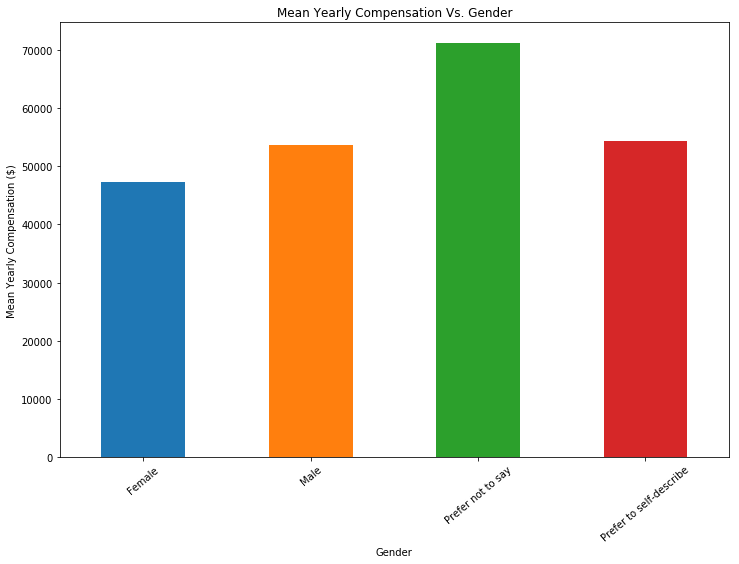

In [32]:
df6['Q9']=df6['Q9'].astype(int)
df2=df6.groupby("Q1").Q9.mean()
df2.plot(kind="bar", figsize=(12,8),title='Mean Yearly Compensation Vs. Gender')
df2.plot.bar(rot=40)
plt.ylabel('Mean Yearly Compensation ($)')
plt.xlabel('Gender')

Previous graph can present the following information:

    1- Mean yearly compensation of survey respondents are between 48,000 and 73,000 dollars
    
    2- Mean yearly compensation of females are less than males and the mean difference is about 8,000$
    
    3- There are 2 other groups who they don't like to declare their gender and their mean compensation is higher than males     and females who answered this question
    
These differences between gender and mean yearly compensation can help us for discreminating data and it is expected that gender will have a high importance in yearly compensation prediction.

In the following graph, we will see the relation between mean yearly compensation and profession of survey respondents.

Text(0.5,0,'Profession')

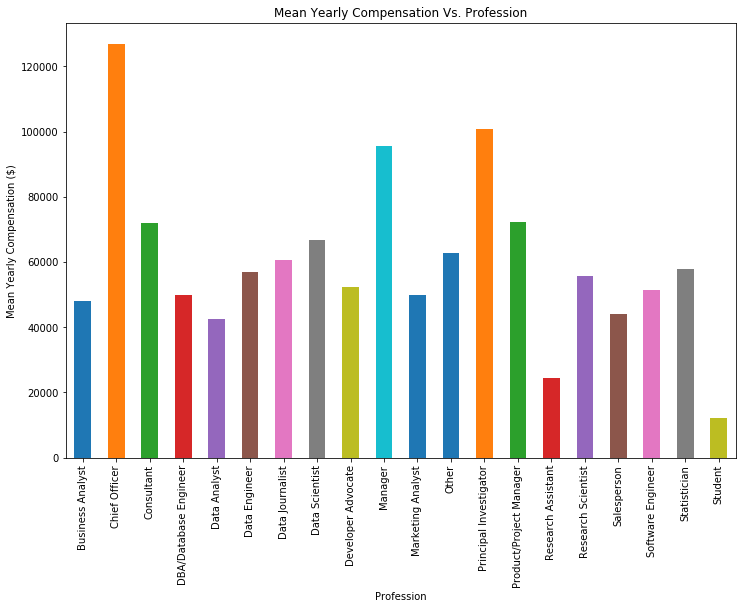

In [33]:
df['Q9']=df['Q9'].astype(int)
df2=df.groupby("Q6").Q9.mean()
df2.plot(kind="bar", figsize=(12,8),title='Mean Yearly Compensation Vs. Profession')
plt.ylabel('Mean Yearly Compensation ($)')
plt.xlabel('Profession')

Previous graph can present the following information:

    1- Chief officers have highest mean yearly compensation and the students and research assistants have the lowest amount of yearly compensation
    
    2- Between 4 types of proffessions of data analyst, data engineer, data scientist, and data journalist there is a huge difference although it seems that these professions are somehow related. Data sientists have the highest mean yearly compensation between these jobs.
    
    3- The survey respondents in this survey vary between salespersons and chief officers. Thus, there is a huge variety of jobs and some questions in this survey was very specific about machine learning details and it is natural to see many question to be without answer.
    
    4- If we have more specific profession categories, we could predict yearly compensation of people in specific industries. What we have now is more general. For example, by having 'Manager' we can not predict that a manager of a company in the field of data science will have yearly compensation of 90,000$.

In the following graph, we will see the relation between mean yearly compensation and age of survey respondents.

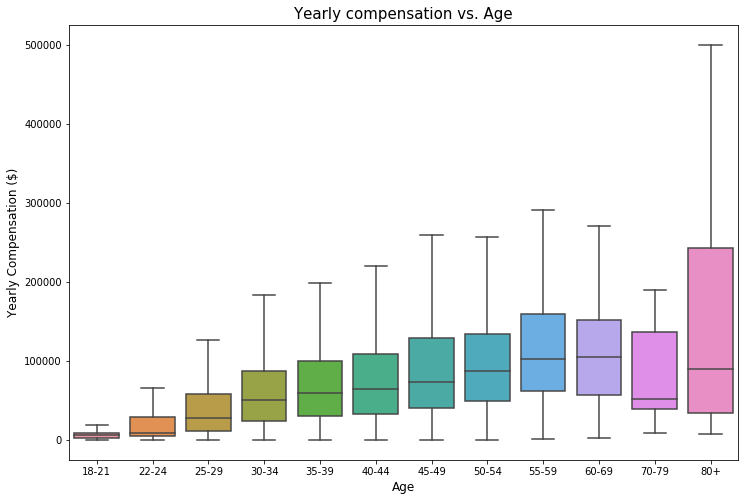

In [34]:
plt.figure(figsize=(12,8))
order = ['18-21', '22-24', '25-29', '30-34','35-39', '40-44', '45-49', '50-54', '55-59', '60-69', '70-79', '80+']
sns.boxplot(x='Q2', y='Q9', data=df, order=order, showfliers=False)
plt.ylabel("Yearly Compensation ($)", fontsize=12)
plt.xlabel("Age", fontsize=12)
plt.title("Yearly compensation vs. Age", fontsize=15)
plt.show()

Previous graph can present the following information:

    1- Our data shows that from 18 years old until 60, the median and maximum Yearly compensation increased

    2- After the age of 60, because of retirement, the yearly compensation will decrease

    3- The minimum compensation in different ages is somehow similar

    4- For the age range of 80+, something seems to be wrong. Based on 2 age range of 60-69 and 70-79 it is expected to see a decrease in compensation but this age category does not show this

    5- The maximum yearly compensation for age category of 80+ doesn't seem to be valid in comparision with other age categories. Thus, the information which is provided for this age category can not be reliable

The trend of data in this graph which is disscused is logical (except for 80+ age category). Thus, it is expected that this feature has high impact on yearly compensation prediction.

In the following graph, we will see the relation between mean yearly compensation and yearly compensation.

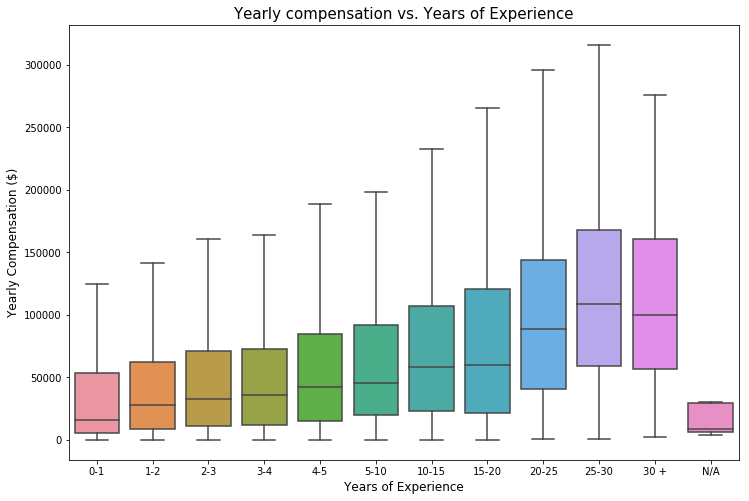

In [35]:
plt.figure(figsize=(12,8))
order = ['0-1', '1-2', '2-3', '3-4','4-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30 +', 'N/A']
sns.boxplot(x='Q8', y='Q9', data=df, order=order, showfliers=False)
plt.ylabel("Yearly Compensation ($)", fontsize=12)
plt.xlabel("Years of Experience", fontsize=12)
plt.title("Yearly compensation vs. Years of Experience", fontsize=15)
plt.show()

Previous graph can present the following information:

    1- Our data shows that from 0 to 30 years of experience, the median and maximum Yearly compensation increased

    2- After 30 years od experience, because of retirement, the yearly compensation will decrease

    3- The minimum compensation in different categories of experience is somehow similar

    4- Unlike the last category of the previous graph that something seems to be wrong, everything is logical here and yearly compensation will decrease in the last category like the 2 previous categories. Moreover, the maximum compensation is also logical and it is decreasing unlike what we saw in previous graph. This is another reason that the data for the last group of previous graph is not valid.

This graph shows us it can be a better feature for prediction of yearly compensation in comparison with age of survey respondents because all data seems to be logical. Another reason for importance of this feature is that professional experience can be a better variable in comparison with age because we can have someone who is 60 years old but he has 5 years of professional experience. Thus, we shouldn't expect him\her to have yearly compensation of some one who is 60 years old and have 30 years of experience.

---------------------------


In this section, we will try to visualize the importance order of features in our database. For this purpose, we will figure correlation plot for different subsets of our data.

As far as most of our data is categorical, it is supposed to see each category of data on correlation plot and by the contour of this graph we can find the importance of each feature with regards to our target variable which is yearly compensation (Q9 on correlation plot).

For having readable outcome and having many features, I decided to plot correlation plot in each subset of data.

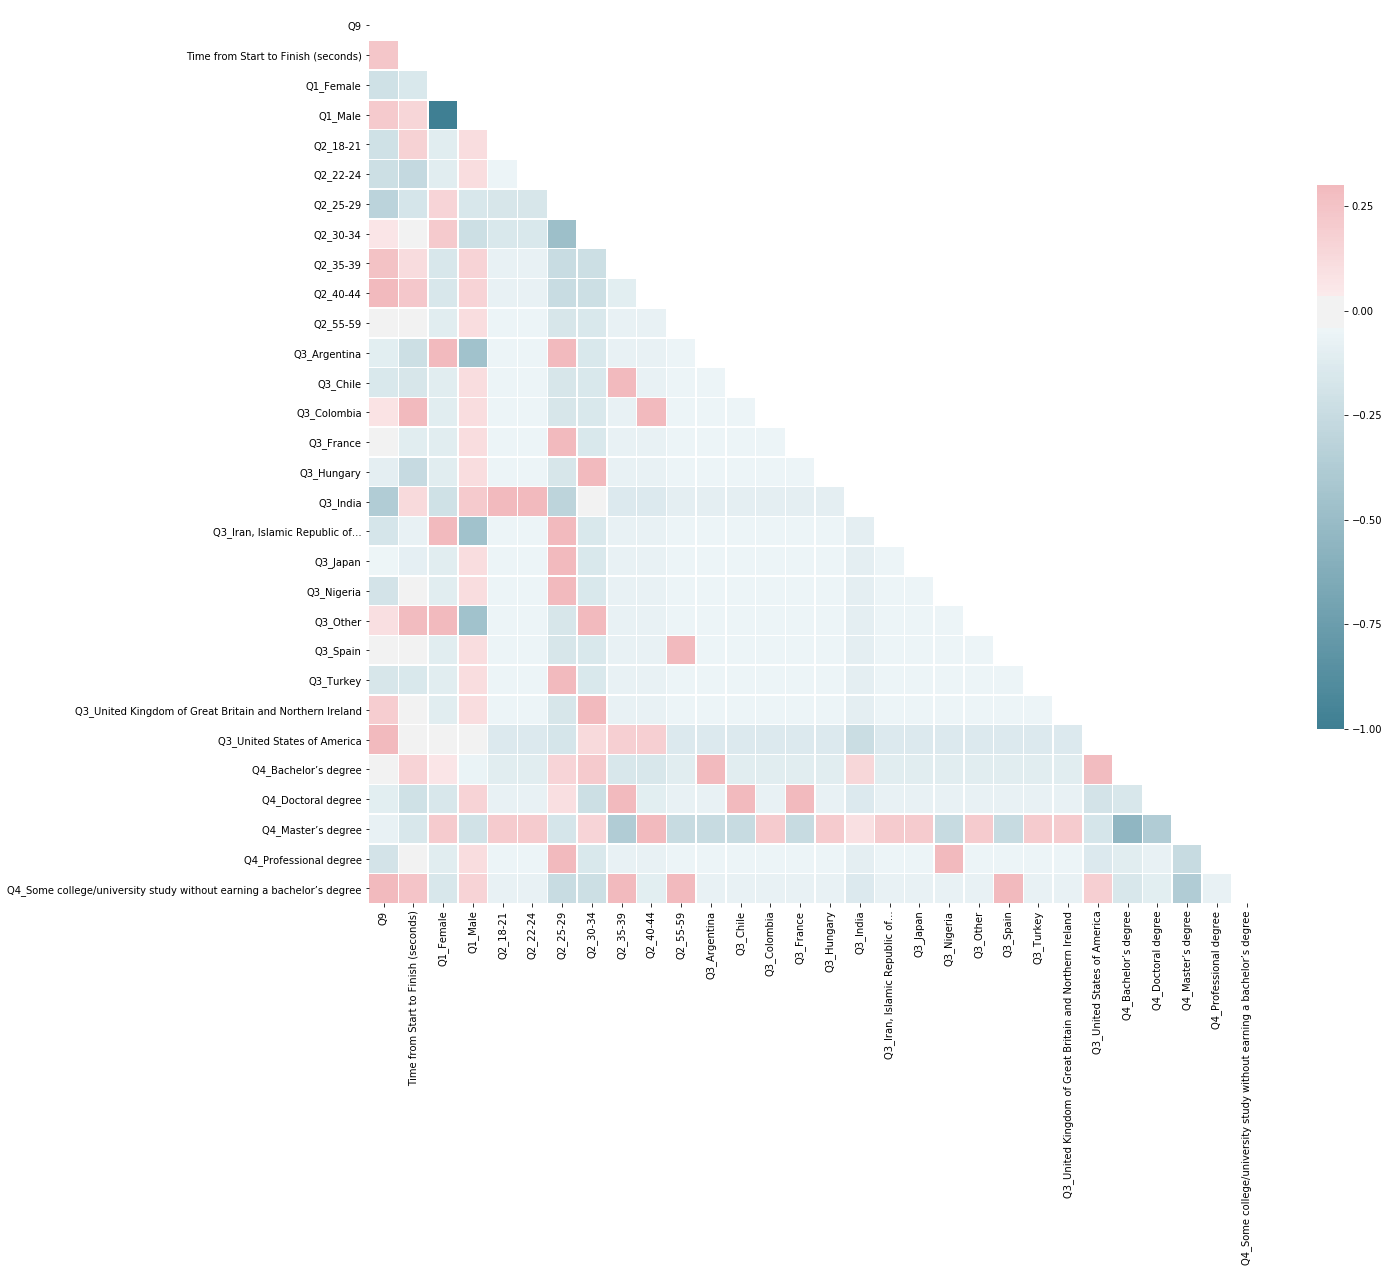

In [36]:
df_Test = df.iloc[0:20,0:5] 
df_Test['Q9']=df['Q9'].astype(int)
cols = df_Test.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_Test2 = df_Test[cols]
df_Test3 = pd.get_dummies(df_Test2)
# Compute the correlation matrix
corr = df_Test3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This correlation plot can show us the following features are most related to yearly compensation of survey respondents:
    
    1- Q1_Male
    
    2- Q1_Female
    
    3- Q2_18-21
    
    4- Q4_Bachelor'_degree
    
    5- Q4_Doctoral_degree
    
    6- Q4_Some college/university study without earning a bachelor's degree
    
    7- Q3_United States of America
    
    8- Q2_40-44
    
    9- Q3_United Kingdom of Great Britain and Northern Ireland
    
    10-Q2_34-39

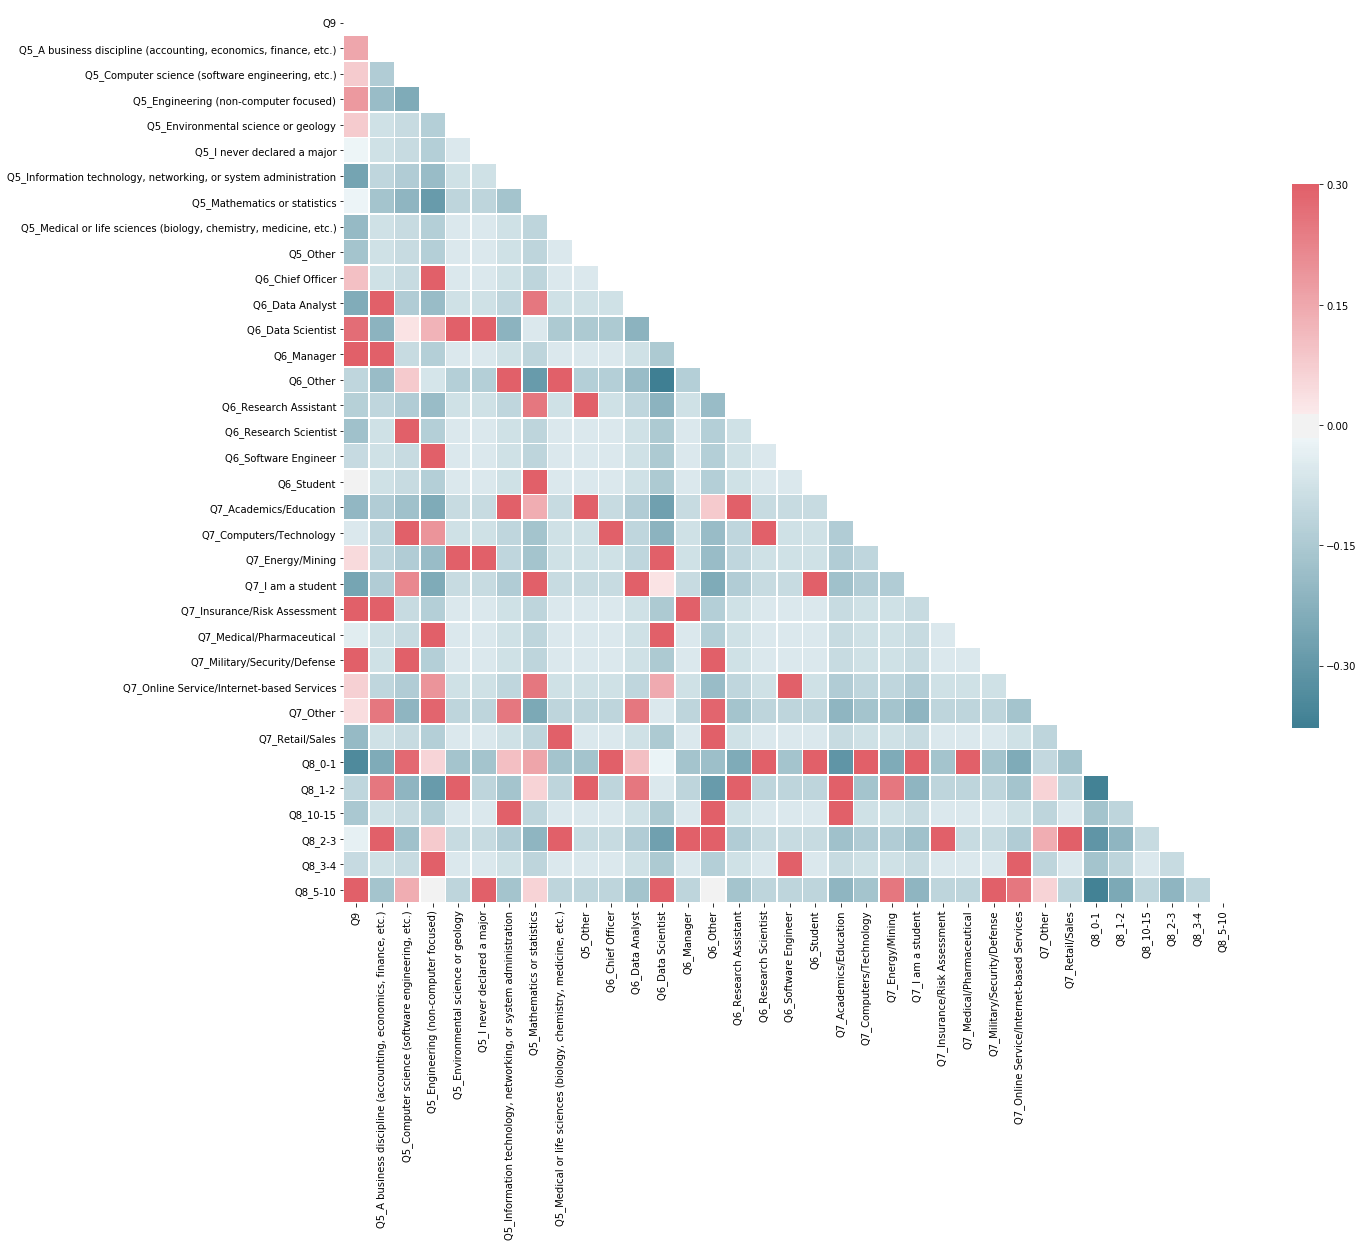

In [37]:
df_Test = df.iloc[0:20,5:10] 
df_Test['Q9']=df['Q9'].astype(int)
cols = df_Test.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_Test2 = df_Test[cols]
df_Test3 = pd.get_dummies(df_Test2)
# Compute the correlation matrix
corr = df_Test3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This correlation plot can show us the following features are most related to yearly compensation of survey respondents:
    
    11- Q6_Data Scientist
    
    12- Q6_Manager
    
    13- Q8_5-10
    
    14- Q7_Military/Security/Defence
    
    15- Q5_Engineering (non-computer focused)
    
    16- Q5_Computer science (software engineering, etc.)
    
    17- Q6_Chief Officer
    
    18- Q6_Data Scientist
    
    19- Q6_Manager

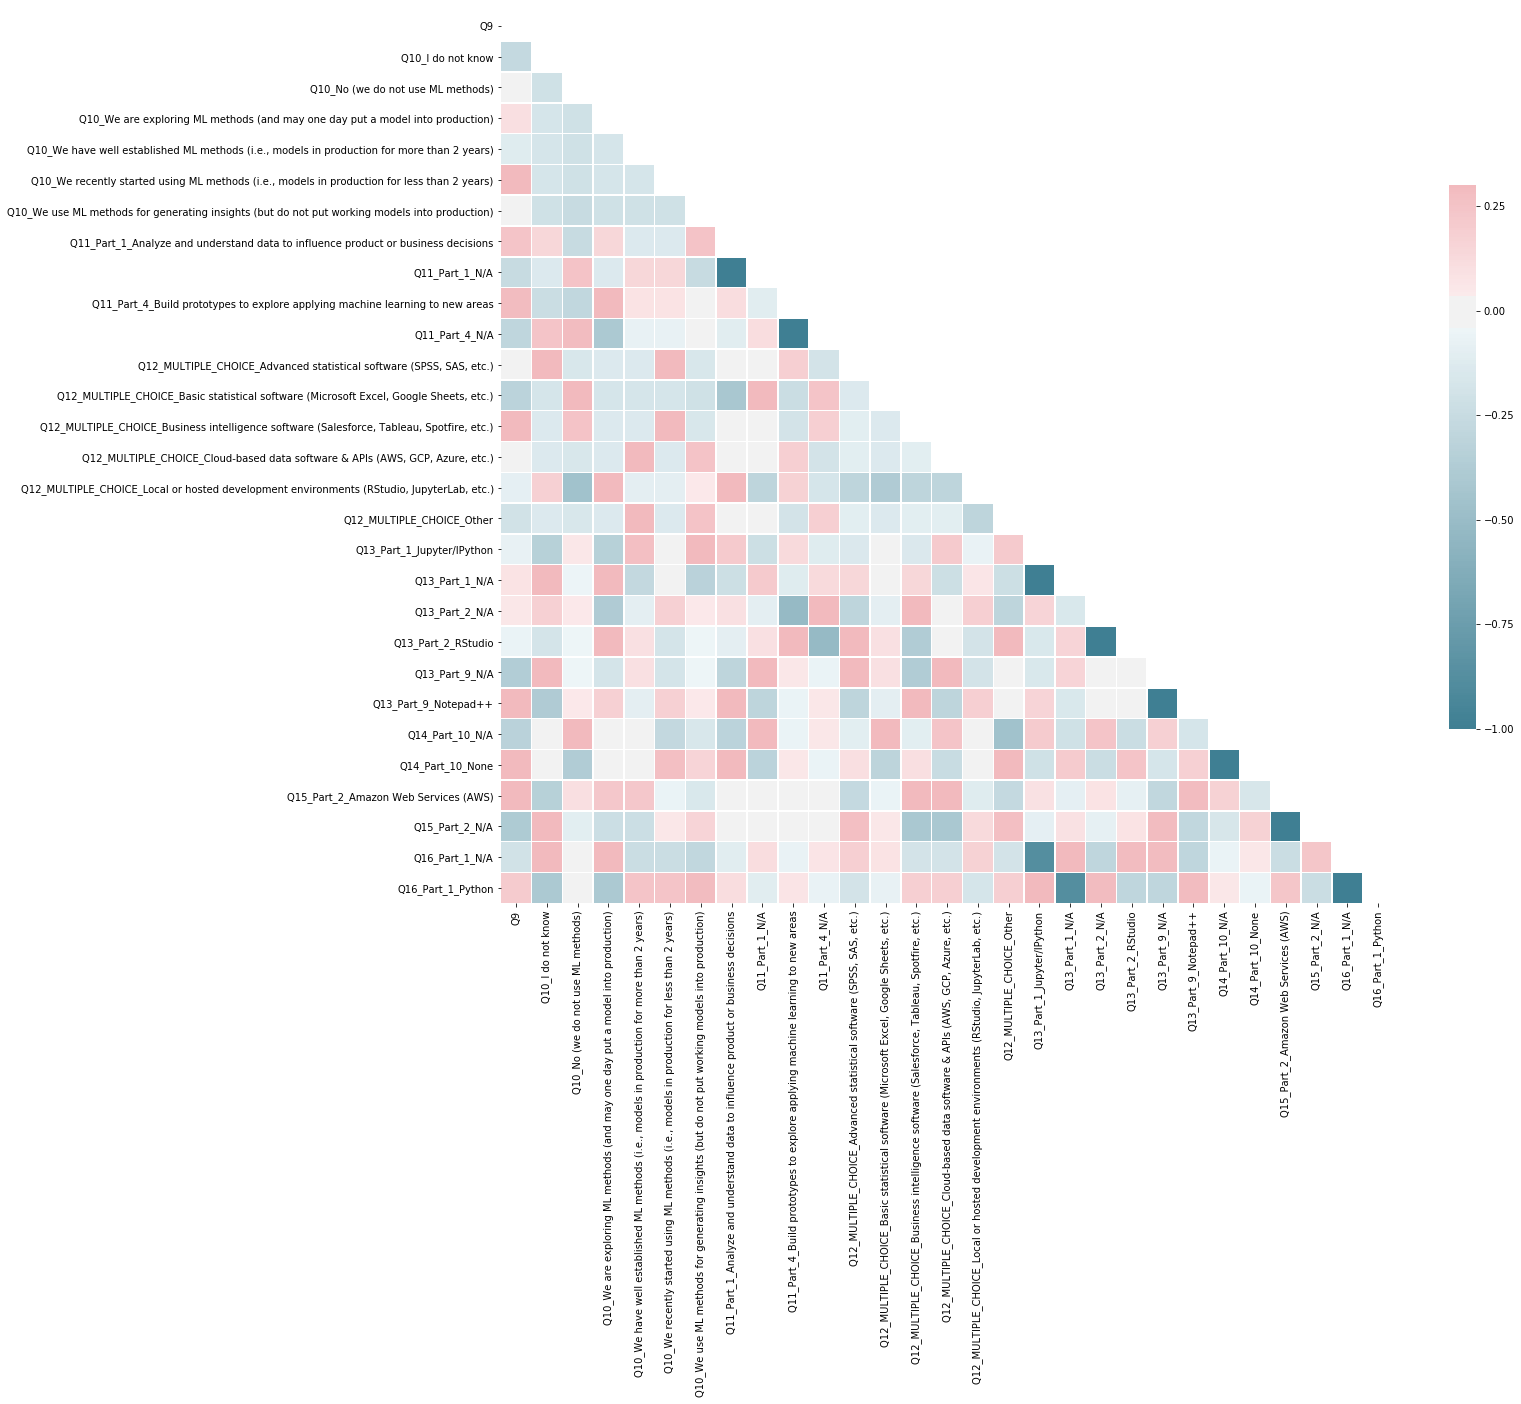

In [38]:
df_Test = df.iloc[0:20,10:20] 
df_Test['Q9']=df['Q9'].astype(int)
cols = df_Test.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_Test2 = df_Test[cols]
df_Test3 = pd.get_dummies(df_Test2)
# Compute the correlation matrix
corr = df_Test3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This correlation plot can show us the following features are most related to yearly compensation of survey respondents:
    
    20- Q16_Part_1_Python
    
    21- Q15_Part_2_Amazon Web Services (AWS)
    
    22- Q14_Part_10_None
    
    23- Q13_Part_9_Notepad++
    
    24- Q11_Part_4_Build prototypes to explore applying machine learning to new areas
    
    25- Q12_Multiple_CHOICES_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)
    
    26- Q11_Part_1_Analyze and understand data to influence product or business decisions
    
    27- We recently started using ML methods (i.e., models in production for less than 2 years)

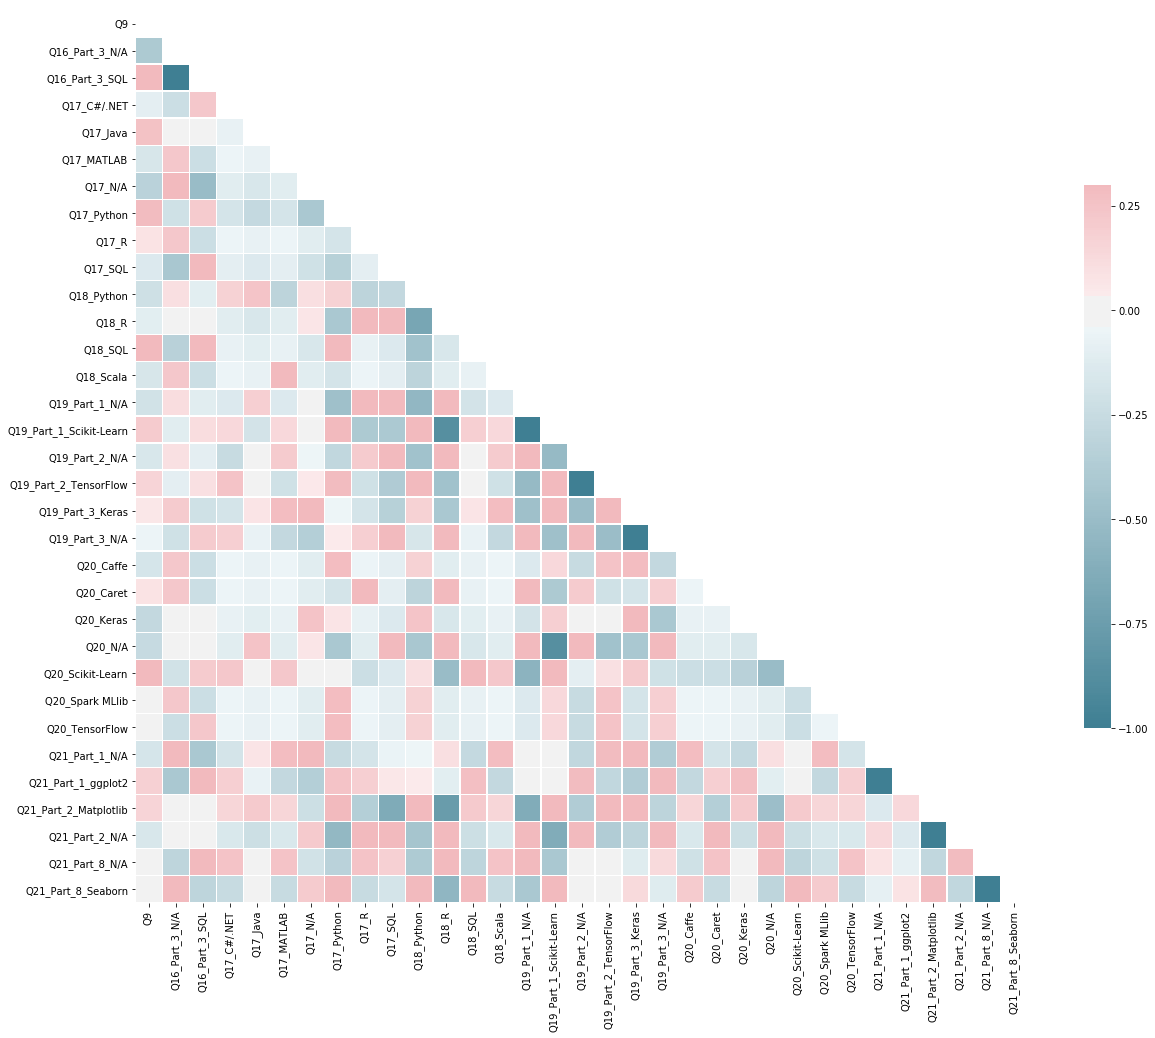

In [39]:
df_Test = df.iloc[0:20,20:30] 
df_Test['Q9']=df['Q9'].astype(int)
cols = df_Test.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_Test2 = df_Test[cols]
df_Test3 = pd.get_dummies(df_Test2)
# Compute the correlation matrix
corr = df_Test3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This correlation plot can show us the following features are most related to yearly compensation of survey respondents:
    
    28- Q20_scikitlearn
    
    29- Q18_SQL
    
    30- Q17_Python
    
    31- Q17_Java
    
    32- Q16_Part_3_SQL
    
    33- Q21_Part_1_ggplot2
    
    34- Q21_Part_2_Matplotlib
    
    35- Q19_Part_1_scikitlearn

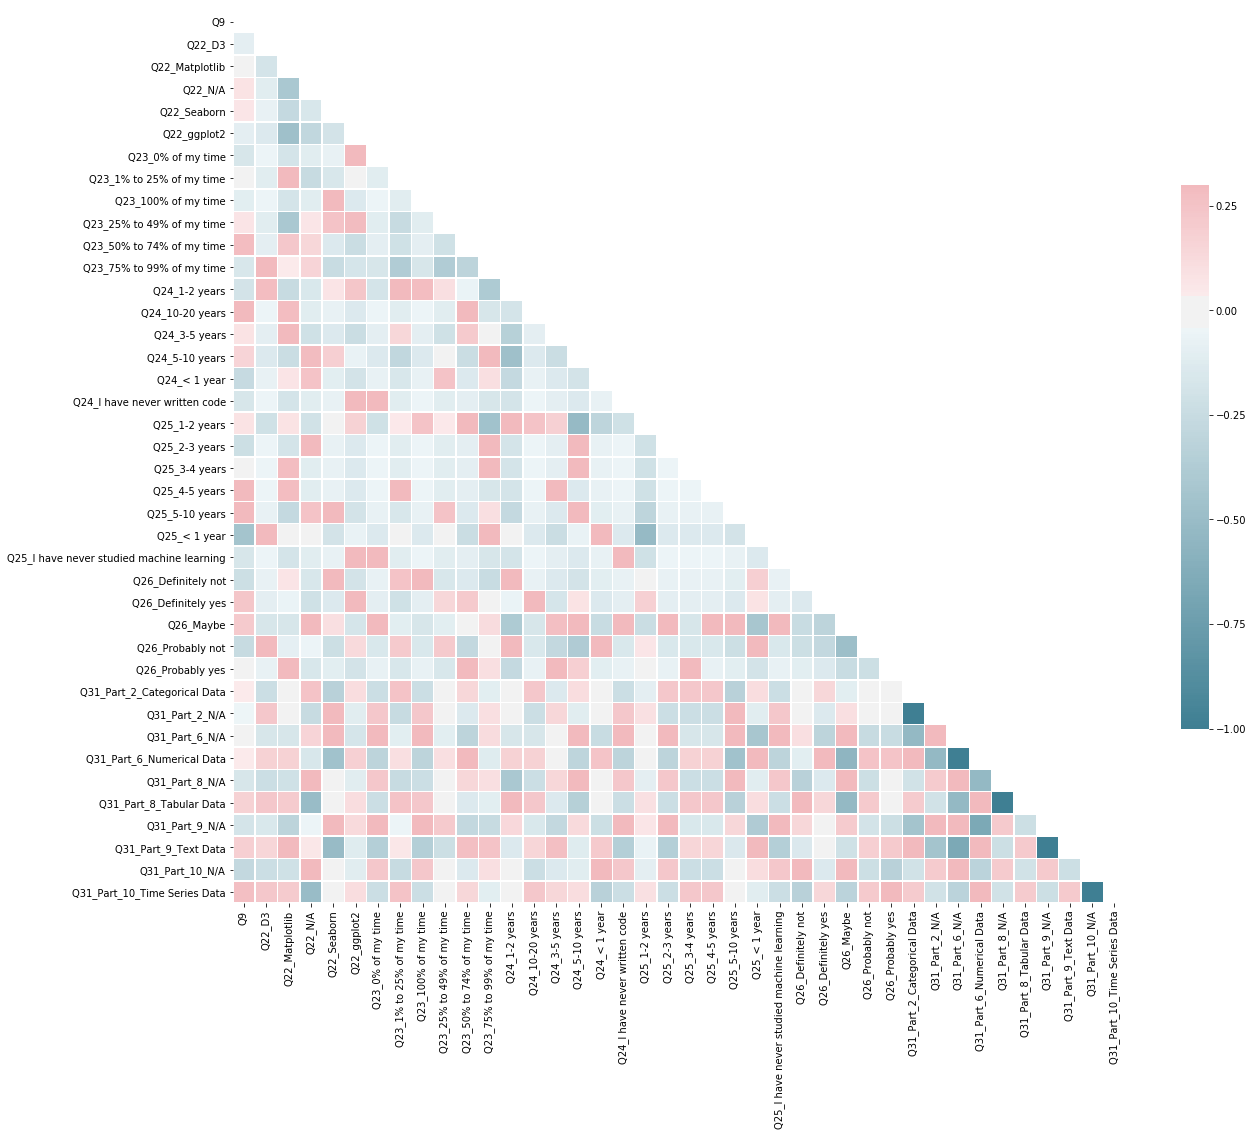

In [40]:
df_Test = df.iloc[0:20,30:40] 
df_Test['Q9']=df['Q9'].astype(int)
cols = df_Test.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_Test2 = df_Test[cols]
df_Test3 = pd.get_dummies(df_Test2)
# Compute the correlation matrix
corr = df_Test3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This correlation plot can show us the following features are most related to yearly compensation of survey respondents:
    
    36- Q24_10-20 years
    
    37- Q25_4-5 years
    
    38- Q23_50% to 75% of my time
    
    39- Q25_4-5 years
    
    40- Q25_5-10 years
    
    41- Q26_Definitely yes

We can just write a simple code for extracting the most important features with regards to yearly compensation. But I didn't do that and I tried to find out important features by their colour in correlation plot because I will use another method in next part for finding important features in our database.

# Part 3: Feature Selection

**Feature Engineering Importance**

Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

The features in our data will directly influence the predictive models we use and the results we can achieve. The better the features that we prepare and choose, the better the results will achieve. Although our results are dependent on many other inter-dependent properties but we need great features that describe the structures inherent in our data.

With well engineered features, we can choose “the wrong parameters” (less than optimal) and still get good results, for much the same reasons. We do not need to work as hard to pick the right models and the most optimized parameters. With good features, we are closer to the underlying problem and a representation of all the data you have available and could use to best characterize that underlying problem.

**Random Forrest Feature Selection Method**

Random forests are one the most popular machine learning algorithms. They are so successful because they provide in general a good predictive performance, low overfitting, and easy interpretability. This interpretability is given by the fact that it is straightforward to derive the importance of each variable on the tree decision. In other words, it is easy to compute how much each variable is contributing to the decision.

Feature selection using Random forest comes under the category of Embedded methods. Embedded methods combine the qualities of filter and wrapper methods. They are implemented by algorithms that have their own built-in feature selection methods. Some of the benefits of embedded methods are :

    -They are highly accurate
    -They generalize better
    -They are interpretable

Random forests consist of 4 –12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or combination of features. At each node (this is at each question), the three divides the dataset into 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived from how “pure” each of the buckets is.

Selecting features by using tree derived feature importance is a very straightforward, fast and generally accurate way of selecting good features for machine learning. In particular, if we are going to build tree methods.

In this assignment, we used RBF method that it's results was 90% similar to what we get from random forrest feature selection method.

As far as we had a combination of encoding methods, some columns of our data which is encoded by get dummies have values between 0 and 1 but others have other numerical values. In this case, it would be better to scale our data to ignore the effect of encoding methods. After using MinMaxScaler, all data would be between 0 and 1.

In [41]:
scaler = MinMaxScaler()
x_dummies = pd.DataFrame(scaler.fit_transform(x_dummies), columns=x_dummies.columns)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(x_dummies, y, test_size = 0.3, random_state = 1)

Now we will use our feature selection technique:

In [43]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 20))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [44]:
selected_feat= X_train.columns[(sel.get_support())]
print('Total Features: {}'.format((X_train.shape[1])))
print('Selected Features: {}'.format(len(selected_feat)))

Total Features: 394
Selected Features: 163


The most important features are as follows:

In [45]:
print(selected_feat)

Index(['Q2', 'Q4', 'Q8', 'Q23', 'Q25', 'Q26', 'Q1_Female', 'Q1_Male',
       'Q3_India', 'Q3_United States of America',
       ...
       'Q47_Part_8_Plot predicted vs. actual results',
       'Q48_I am confident that I can explain the outputs of most if not all ML models',
       'Q48_I am confident that I can understand and explain the outputs of many but not all ML models',
       'Q48_I do not know; I have no opinion on the matter',
       'Q48_I view ML models as "black boxes" but I am confident that experts are able to explain model outputs',
       'Q48_Yes, most ML models are "black boxes"',
       'Q49_Part_6_Make sure the code is well documented', 'Q49_Part_6_N/A',
       'Q49_Part_7_Make sure the code is human-readable', 'Q49_Part_7_N/A'],
      dtype='object', length=163)


By the following chart we can see the distribution of feature's importances in our model:

Text(0.5,0,'Feature Importance')

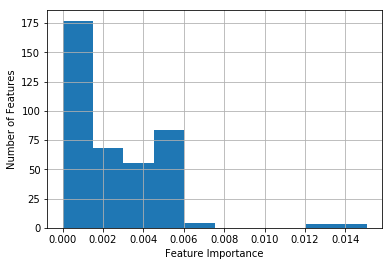

In [46]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()
plt.ylabel('Number of Features')
plt.xlabel('Feature Importance')

We used another method (SVR RFE) for feature selection and it provides quite similar results:

In [47]:
#estimator = SVR(kernel="linear")
#selector = RFE(estimator, 20, step=30)
#selector = selector.fit(X_train,y_train)
#selector.support_ 

In [48]:
#selector_feat= X_train.columns[(selector.support_ )]
#selector_feat

# Part 4: Model Implementation

First of all, we should choose our selected features from previous part for model implementation and producing new training and test data.

In [49]:
x_dummies_new=x_dummies[selected_feat]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(x_dummies_new, y, test_size = 0.3, random_state = 1000)

### 10-fold Cross-validation of 5 Different Regression Algorithms

Cross validation is a technique used to identify how well our model performed and there is always a need to test the accuracy of our model to verify that, our model is well trained with data without any overfitting and underfitting. This process of validation is performed only after training the model with data.

In 10-Fold cross validation, the data is divided into 10 subsets and train our model on 9 subsets and hold the last one for test. This process is repeated 10 times, such that each time, one of the 10 subsets is used as the test set/validation set and the other 9 subsets are put together to form a training set. We then average the model against each of the folds and then finalize our model. After that we test it against the test set.

The more the number of folds, less is value of error due to bias but increasing the error due to variance will increase; the more folds you have, the longer it would take to compute it and you would need more memory. With a lower number of folds, we’re reducing the error due to variance, but the error due to bias would be bigger. It would also computationally cheaper.

One round of cross-validation involves partitioning a sample of data into complementary subsets, performing the analysis on one subset (called the training set), and validating the analysis on the other subset (called the validation set or testing set).

The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

Due to repetative MemoryERROR that I received from Jupyter Notebook, I have to choose a subset of data otherwise I can not run algorithms further. The subset which I considered have 15 of the most important features which are extraceted from feature selection section. Moreover, I chose to have 7200  row of data for having at least 5000 training point.

If I wantt to talk about the effect of having a subset of data, I should say that it depends on data set. For example, in our database, when I extracted a subset of data, the accuracy of KNN algorithm increased 8% but the accuracy of Linear Regression didn't change more than 1%. This also can show us the linear regression model can better predict our data with having dependency on data size. All in all, in case we have to select a subset of data, it would be better to take a random set of data.

In [50]:
x_dummies_new_subset=x_dummies_new.iloc[:,0:15]
X_train_new_subset, X_test_new_subset, y_train_new_subset, y_test_new_subset = train_test_split(x_dummies_new_subset[0:7200], y[0:7200], test_size = 0.3, random_state = 1000)
X_train_new_subset=X_train_new_subset.astype(float)
X_test_new_subset=X_test_new_subset.astype(float)
y_train_new_subset=y_train_new_subset.astype(float)
y_test_new_subset=y_test_new_subset.astype(float)
X_train_new_subset.head()

,Q2,Q4,Q8,Q23,Q25,Q26,Q1_Female,Q1_Male,Q3_India,Q3_United States of America,"Q5_A business discipline (accounting, economics, finance, etc.)","Q5_Computer science (software engineering, etc.)",Q5_Engineering (non-computer focused),Q5_Mathematics or statistics,Q5_Physics or astronomy
4627,0.083333,0.500000,0.0,0.8,0.250,0.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5169,0.333333,0.666667,1.0,0.4,0.125,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5139,0.083333,0.333333,0.1,0.6,0.250,0.75,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5647,0.250000,0.500000,0.1,0.6,0.125,0.75,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4356,0.250000,0.333333,0.1,0.4,0.000,0.00,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


#### A) KNN Regression Algorithm



This method is used for both classification and regression. It is among the simplest method of machine learning algorithms. It stores the cases and for new data it checks the majority of the k neighbours with which it resembles the most. KNN makes predictions using the training dataset directly.

KNN Advantages:

    • The computation cost is very high since the algorithm hast to compute distance to all training samples which leads to the curse of dimensionality

    • KNN is not parametric

    • Is not influenced by noise in the data

    • Every decision is based on locality

    • Easy to implement

KNN Disadvantages:

    • If you increase the number of features the computational cost increase exponentially

    • It’s hard to find what K distance function should use without experimentation. Therefore, are hard to interpret it.

    • The query time of KNNs is higher than the training time, since is a lazy learner.

In [51]:
knn = KNeighborsRegressor(n_neighbors=50)
scores = cross_val_score(knn,X_train_new_subset,y_train_new_subset, cv=10)
print("KNN 10-Fold Cross Validation:{}" .format(scores))
print("KNN Variance Accuracy:{}".format(np.var(scores)))
print("KNN Average Accuracy of Training Set: %.2f%% " % (np.mean(scores)*100.0))

KNN 10-Fold Cross Validation:[0.37624722 0.25468205 0.32741333 0.36041789 0.39999013 0.26806182
 0.40115483 0.32077024 0.39339443 0.36578273]
KNN Variance Accuracy:0.0025106414911113778
KNN Average Accuracy of Training Set: 34.68% 


The 10-fold KNN cross validation over our data shows that the second and the sixth folds have the highest  difference with mean accuracy between folds. This shows that this model could not predict the accuracy of these 2 folds as same as other folds which can caused by non evenly distributed data at these folds.

    
I chose KNN as a regression model in this assignment becasue it is not influenced by noise in the database like what we have and the results that we got also shows that this model performed good enough.

#### B) Linear Regression Algorithm


For statistical technique linear regression is used in which value of dependent variable is predicted through independent variables. A relationship is formed by mapping the dependent and independent variable on a line and that line is called regression line which is represented by Y= a*X + b.

Where Y= Dependent variable (e.g weight).

X= Independent Variable (e.g height)

b= Intercept and a = slope.

Linear Regression Advantages:

    • Very fast (runs in constant time)

    • Easy to understand the model

    • Less prone to overfitting

Linear Regression Disadvantages:

    • Unable to model complex relationships
    
    • Unable to capture nonlinear relationships without first transforming the inputs

In [52]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train_new_subset,y_train_new_subset, cv=10)
print("Linear Regression 10-Fold Cross Validation:{}" .format(scores))
print("Linear Regression Variance Accuracy:{}".format(np.var(scores)))
print("Linear Regression Average Accuracy of Training Set: %.2f%% " % (np.mean(scores)*100.0))

Linear Regression 10-Fold Cross Validation:[0.42941633 0.3248395  0.38960597 0.44358638 0.41828432 0.34883629
 0.42465282 0.35364969 0.45287031 0.3940229 ]
Linear Regression Variance Accuracy:0.0017020431742709337
Linear Regression Average Accuracy of Training Set: 39.80% 


The 10-fold Linear Regression cross validation over our data shows that the second and the sixth folds have the highest difference with mean accuracy between folds. This shows that this model could not predict the accuracy in these 2 folds as same as other folds which can caused by non evenly distributed data at these folds.

If we want to make a comparison between KNN and Linear Regression, we can see that linear regression could predict the acuraccies of fold 2 and 6 with lower distance from mean accuracy in comparison to KNN model.



I chose Linear Regression as a regression model in this assignment becasue it is so fast and the results shoow that this model works well with this data.

#### C) Logistic Regression Algorithm


In logistic regression we have lots of data whose classification is done by building an equation. This method is used to find the discrete dependent variable from the set of independent variables. Its goal is to find the best fit set of parameters. In this classifier, each feature is multiplied by a weight and then all are added. Then the result is passed to sigmoid function which produces the binary output. Logistic regression generates the coefficients to predict a logit transformation of the probability.

Logistic Regression Advantages:

    • Low Variance

    • Probability for outcomes

    • Robust to noise

    • Can also be used in big data scenarios.

Logistic Regression Disadvantages:

    • Can hardly handle categorical features.

    • High bias

    • You must assume the features are roughly linear and the problem is linearly separable.

    • Limited to capture complex features in the data, when are not linear.

In [53]:
lor = LogisticRegression(random_state=1)
scores = cross_val_score(lor, X_train_new_subset,y_train_new_subset, cv=10)
print("Logistic Regression 10-Fold Cross Validation:{}" .format(scores))
print("Logistic Regression Variance Accuracy:{}".format(np.var(scores)))
print("Logistic Regression Average Accuracy of Training Set: %.2f%% " % (np.mean(scores)*100.0))

Logistic Regression 10-Fold Cross Validation:[6.13120785e-04 1.47058824e-02 2.50000000e-01 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00]
Logistic Regression Variance Accuracy:0.21372944177849923
Logistic Regression Average Accuracy of Training Set: 62.65% 


10-fold cross validation with logistic regression algorithm shows a huge difference between the accuracy of each fold and the mean accuracy. Although our average accuracy is higher than other algorithms, this model can not present a valid prediction for our data becasue of this variablity between fold accuracies. This can happen in models with high complexity and experiencing overfitting on training data.


I chose Logistic Regression as a regression model in this assignment because it is robust to noise. Our database and having lots of dimensions with low importances showed that it is a bit noisy.
The outcome of using this method shows that having non-linear data, made this method not a good option for this database.

#### D) Decision Tree Algorithm


Decision tree methods construct a model of decisions made based on actual values of attributes in the data.

Decisions fork in tree structures until a prediction decision is made for a given record. Decision trees are trained on data for classification and regression problems.

Decision Tree Advantages:

    • Can analyse both numerical and categorical data

    • Non-parametric

    • Work fast if is a simple structure.

Decision Tree Disadvantages:
    
    • Tends to overfit with many features but we can pick the optimal max-depth to avoid the problem

In [54]:
td = tree.DecisionTreeRegressor(random_state=1,max_depth=6)
scores=cross_val_score(td, X_train_new_subset, y_train_new_subset, cv=10)
print("Decision Tree 10-Fold Cross Validation:{}" .format(scores))
print("Decision Tree Variance Accuracy:{}".format(np.var(scores)))
print("Decision Tree Average Accuracy of Training Set: %.2f%% " % (np.mean(scores)*100.0))

Decision Tree 10-Fold Cross Validation:[ 0.3975342   0.32695968  0.41437957  0.344458    0.35634417  0.31684991
  0.42136002  0.13308805  0.40758333 -0.30801789]
Decision Tree Variance Accuracy:0.04490157696140004
Decision Tree Average Accuracy of Training Set: 28.11% 


10-fold cross validation with decision tree shows that for the 8th fold, there is a considerable difference between this fold accuracy and average accuracy. Thus, this model can not predict one of folds as good as other. It should be noted that the average accuracy of this model is lower than KNN and linear regression.

I chose Decision Tree as a regression model in this assignment becasue it is fast and computationally efficient. Decision tree perform very fast in this project and the output result is also acceptable but it is not as good as linear regression model.

#### E) SVM Algorithm



Support vector machine is a binary classifier. Raw data is drawn on the n- dimensional plane. In this a separating hyperplane is drawn to differentiate the datasets. The line drawn from centre of the line separating the two closest data-points of different categories is taken as an optimal hyperplane. This optimised separating hyperplane maximizes the margin of training data. Through this hyperplane, new data can be categorised.

SVM Advantages:

    • Works well in complex domains where there is not a clear margin of separation.

    • Perform well with non-linear boundary (depends of the kernel used)

    • Handle high dimensional data well

    • Best suited for problems with complex domains where there are clear margins of data separation.

    • Separation planes through custom kernels.

SVM Disadvantages:

    • Don’t perform well in larger data sets, because the training time happens to be cubic to the size of the data set.

    • Needs fine tune the parameters

    • Don’t work well with noise data. So, where the classes are very overlapping, you must count independent evidence.

    • Susceptible to over-fitting when the data has noisy or overlaps.

    • Long train in large data sets

I chose SVM as a regression model in this assignment becasue it can handle high dimentional database like what we have here very well. 

In [81]:
#SVM
from sklearn import svm
clf =  svm.SVC(random_state=1,C=10)
scores=cross_val_score(clf, X_train_new_subset, y_train_new_subset, cv=10)
print("SVM 10-Fold Cross Validation:{}" .format(scores))
print("SVM Variance Accuracy:{}".format(np.var(scores)))
print("SVM Average Accuracy of Training Set: %.2f%% " % (np.mean(scores)*100.0))

SVM 10-Fold Cross Validation:[6.13120785e-04 7.35294118e-03 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00000000e+00]
SVM Variance Accuracy:0.2393675246277712
SVM Average Accuracy of Training Set: 40.08% 


10-fold cross validation with SVM algorithm shows a huge difference between the accuracy of each fold and the mean accuracy. Although our average accuracy is as good as other algorithms like KNN, this model can not present a valid prediction for our data becasue of huge difference between accuracies in each fold. This can happen in models with high complexity and experiencing overfitting on training data.

Thus, It seems that this algorithm was not a good choice and this happened becasue of high noise in our data.

### BONUS: 10-fold Cross-validation of Regularization Algorithms

In [55]:
#Lasso
la = linear_model.Lasso(alpha = 2.0,max_iter=20000)
scores = cross_val_score(la, X_train_new_subset,y_train_new_subset, cv=10)
print("Lasso 10-Fold Cross Validation:{}" .format(scores))
print("Lasso Variance Accuracy:{}".format(np.var(scores)))
print("Lasso Average Accuracy of Training Set: %.2f%% " % (np.mean(scores)*100.0))

Lasso 10-Fold Cross Validation:[0.42943163 0.32484743 0.38958688 0.44356407 0.41824198 0.3489865
 0.42466882 0.35363734 0.4528474  0.39421249]
Lasso Variance Accuracy:0.0017000026577379227
Lasso Average Accuracy of Training Set: 39.80% 


The accuracies which is provided by Lasso model also confirm that the first and sixth fold have the highest accuracies and the second fold has the least accuracy.

In [56]:
#Ridge
ri = Ridge(alpha = 1.0,max_iter=20000)
scores = cross_val_score(ri, X_train_new_subset,y_train_new_subset, cv=10)
print("Ridge 10-Fold Cross Validation:{}" .format(scores))
print("Ridge Variance Accuracy:{}".format(np.var(scores)))
print("Ridge Average Accuracy of Training Set: %.2f%% " % (np.mean(scores)*100.0))

Ridge 10-Fold Cross Validation:[0.42950963 0.32474775 0.38949954 0.4432796  0.41861669 0.34873059
 0.42466814 0.35390374 0.45270692 0.39507946]
Ridge Variance Accuracy:0.0016990762446043334
Ridge Average Accuracy of Training Set: 39.81% 


The accuracies which is provided by Ridge model also confirm that the first and sixth fold have the highest accuracies and the second fold has the least accuracy.

Based on 2 previous regularization methods, regularization does not have a huge effect on accuracies and trends of 10 fold cross validation.

### Bias -Variance Trade-off 

If our model is too simple and has very few parameters then it may have high bias and low variance. On the other hand if our model has large number of parameters then it’s going to have high variance and low bias. So we need to find the right/good balance without overfitting and underfitting the data.

This tradeoff in complexity is why there is a tradeoff between bias and variance. An algorithm can’t be more complex and less complex at the same time.

To build a good model, we need to find a good balance between bias and variance such that it minimizes the total error.

![a](https://cdn-images-1.medium.com/max/800/1*e7VaoBh5apjaM2p4afkFyg.png)
![b](https://cdn-images-1.medium.com/max/800/1*RQ6ICt_FBSx6mkAsGVwx8g.png)

The bias is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).

The variance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting).

When we have a model with underfitting, it means that our model is not fitted to our training data and the training error is higher than testing error. The previous figure shows that when we experience underfitting, bias is higher than variance.

When we have a model with overfitting, it means that our model is not fitted to our testing data ( the model is overfitted to training data) and the testing error is higher than training error. The previous figure shows that when we experience overfitting, variance is higher than bias.

Thus, in this section we will find out the trade-off between bias and variance with training and testing error.



An optimal balance of bias and variance would never overfit or underfit the model.

Now we will show the error plot of each algorithms we used in previous part. 

#### A) KNN Bias-Variance Trade-off:

No handles with labels found to put in legend.


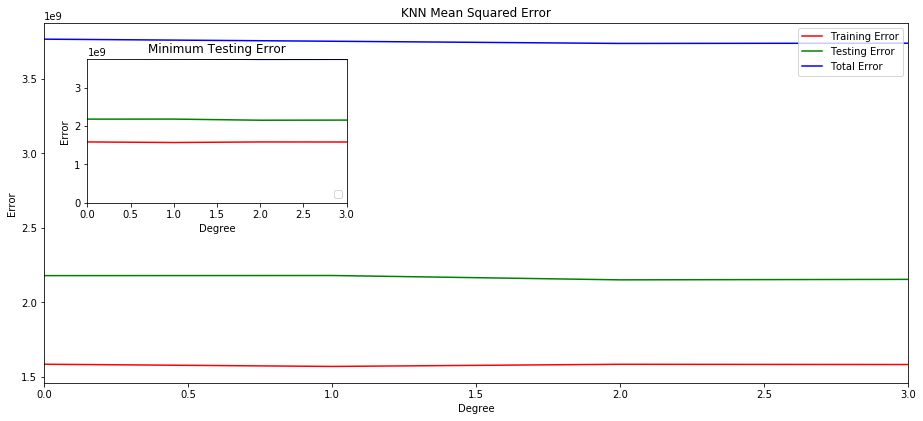

In [57]:
steps = np.arange(1,5,1)
tr_score = np.zeros(steps.shape)
tst_score = np.zeros(steps.shape)
trainErr = np.zeros(steps.shape)
testErr = np.zeros(steps.shape)

for i, step in enumerate(steps):
    # Generate polynomial features
    poly = PolynomialFeatures(step, interaction_only=True)
    pX_train = poly.fit_transform(X_train_new_subset.astype(float))
    pX_test = poly.transform(X_test_new_subset.astype(float))

    # Create model instance
    model = KNeighborsRegressor()

    # Train model
    model.fit(pX_train, y_train_new_subset.astype(float))

    # Make Predictions
    y_train_pred = model.predict(pX_train)
    y_test_pred = model.predict(pX_test)

    # Calculate Error and accuracy
    tr_score[i]=r2_score(y_train_new_subset.astype(float), y_train_pred)
    tst_score[i]=r2_score(y_test_new_subset.astype(float), y_test_pred)
    trainErr[i] = mean_squared_error(y_train_new_subset.astype(float), y_train_pred)
    testErr[i] = mean_squared_error(y_test_new_subset.astype(float), y_test_pred)
#print("KNN Average Accuracy Based on Bias-Variance Trade-off of Training Data:")
#print(tr_score[1])
#print("KNN Average Accuracy Based on Bias-Variance Trade-off of Test Data:")
#print(tst_score[1])

fig = plt.figure(figsize=(12,5))

totalErr = trainErr + testErr

axes1 = fig.add_axes([0, 0, 1, 1]) # main axes
axes2 = fig.add_axes([0.05, .5, .3, .4]) # inner axes

axes1.plot(trainErr,'r',label='Training Error')
axes1.plot(testErr,'g',label='Testing Error')
axes1.plot(totalErr, 'b', label='Total Error')

axes1.set_title("KNN Mean Squared Error")
axes1.set_xlabel("Degree")
axes1.set_ylabel("Error")
axes1.set_xlim(0,steps[-2])
axes1.legend(loc=1)

axes2.plot(trainErr,'r')
axes2.plot(testErr,'g')
axes2.plot(totalErr,'b')
axes2.set_xlim(0,steps[-2])
axes2.set_ylim(0, totalErr[1]+10)
axes2.set_title("Minimum Testing Error")
axes2.set_xlabel("Degree")
axes2.set_ylabel("Error")

plt.legend(loc=4)

In [58]:
print("KNN Average Accuracy Based on Bias-Variance Trade-off of Training Data: %.2f%% " % (tr_score[0]*100.0))
print("KNN Average Accuracy Based on Bias-Variance Trade-off of Testing Data: %.2f%% " % (tst_score[0]*100.0))

KNN Average Accuracy Based on Bias-Variance Trade-off of Training Data: 55.17% 
KNN Average Accuracy Based on Bias-Variance Trade-off of Testing Data: 33.42% 


In this model, our testing error is higher than our training error or we can say that variance is higher than bias. Thus, this model is overfitted to our training data. Moreover, previous figure also shows that with increasing degree of complexity, training error will increase slightly. Thus, due to overfitting, KNN can not be a good option for being our best model.

#### B) Linear Regression Bias-Variance Trade-off:

No handles with labels found to put in legend.


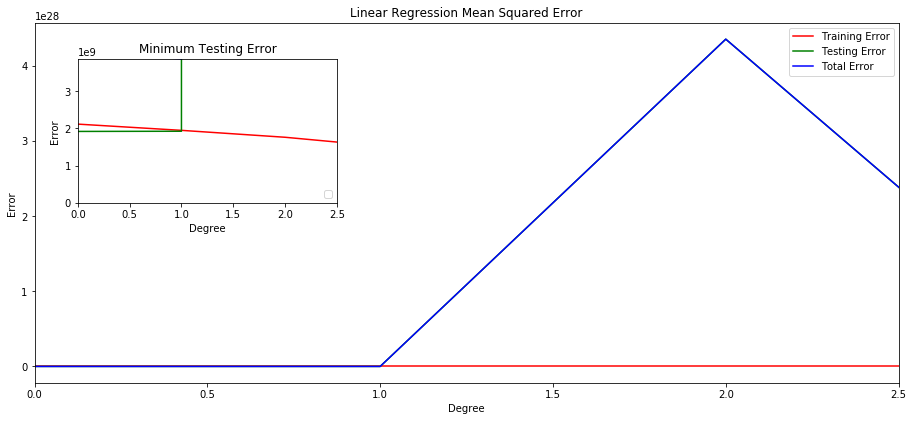

In [59]:
steps = np.arange(1,5,1)

tr_score = np.zeros(steps.shape)
tst_score = np.zeros(steps.shape)
trainErr = np.zeros(steps.shape)
testErr = np.zeros(steps.shape)

for i, step in enumerate(steps):
    # Generate polynomial features
    poly = PolynomialFeatures(step, interaction_only=True)
    pX_train = poly.fit_transform(X_train_new_subset)
    pX_test = poly.transform(X_test_new_subset)
    
    # Create model instance
    model = LinearRegression()
    
    # Train model
    model.fit(pX_train, y_train_new_subset)
    
    # Make Predictions
    y_train_pred = model.predict(pX_train)
    y_test_pred = model.predict(pX_test)
    
    # Calculate Error and accuracy
    tr_score[i]=r2_score(y_train_new_subset, y_train_pred)
    tst_score[i]=r2_score(y_test_new_subset, y_test_pred)
    trainErr[i] = mean_squared_error(y_train_new_subset, y_train_pred)
    testErr[i] = mean_squared_error(y_test_new_subset, y_test_pred)
#print("Linear Regression Average Accuracy Based on Bias-Variance Trade-off of Training Data:")
#print(tr_score)
#print("Linear Regression Average Accuracy Based on Bias-Variance Trade-off of Test Data:")
#print(tst_score)
fig = plt.figure(figsize=(12,5))

totalErr = trainErr + testErr

axes1 = fig.add_axes([0, 0, 1, 1]) # main axes
axes2 = fig.add_axes([0.05, .5, .3, .4]) # inner axes

axes1.plot(trainErr,'r',label='Training Error')
axes1.plot(testErr,'g',label='Testing Error')
axes1.plot(totalErr, 'b', label='Total Error')

axes1.set_title("Linear Regression Mean Squared Error")
axes1.set_xlabel("Degree")
axes1.set_ylabel("Error")
axes1.set_xlim(0,steps[-2]-0.5)
axes1.legend(loc=1)

axes2.plot(trainErr,'r')
axes2.plot(testErr,'g')
axes2.plot(totalErr,'b')
axes2.set_xlim(0,steps[-2]-0.5)
axes2.set_ylim(-1.0, totalErr[1]+10)
axes2.set_title("Minimum Testing Error")
axes2.set_xlabel("Degree")
axes2.set_ylabel("Error")

plt.legend(loc=4)

In [60]:
print("Linear Regression R2 Accuracy Based on Bias-Variance Trade-off of Training Data: %.2f%% " % (tr_score[1]*100.0))
print("Linear Regression R2 Accuracy Based on Bias-Variance Trade-off of Testing Data: %.2f%% " % (tst_score[1]*100.0))

Linear Regression R2 Accuracy Based on Bias-Variance Trade-off of Training Data: 44.97% 
Linear Regression R2 Accuracy Based on Bias-Variance Trade-off of Testing Data: 41.28% 


In this model, between 0 and 1 degree of complexity, the training and testing error have the same amount and in other words, there is not much difference between bias and variance and the model is not overfitted or underfitted to training data. The accuracy of our model also shows that the accuracies are close.

With increasing the degree of complexity, testing error will increase substantially or in other words, the variance of our data will become higher than bias and our model experience overfitting.
Thus, until 1 degree of complexity, **Linear regression works well and can be an option for the best model!**

#### C) Decision Tree Bias-Variance Trade-off:

No handles with labels found to put in legend.


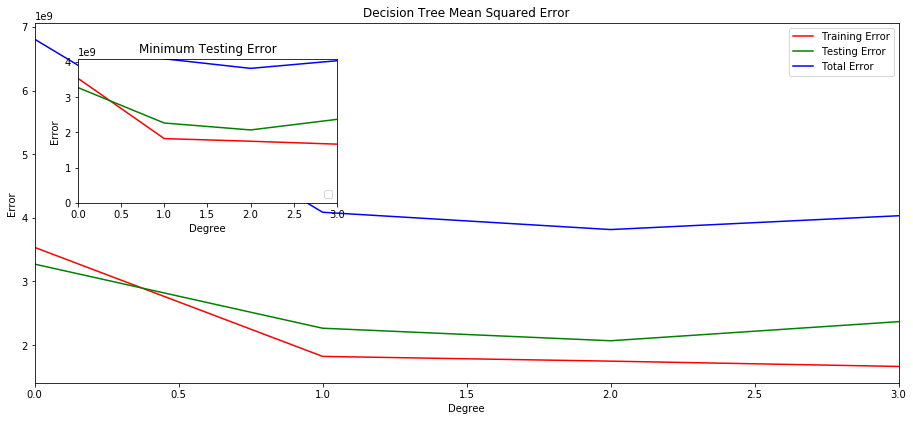

In [61]:
steps = np.arange(0,5,1)

tr_score = np.zeros(steps.shape)
tst_score = np.zeros(steps.shape)
trainErr = np.zeros(steps.shape)
testErr = np.zeros(steps.shape)

for i, step in enumerate(steps):
    # Generate polynomial features
    poly = PolynomialFeatures(step, interaction_only=True)
    pX_train = poly.fit_transform(X_train_new_subset)
    pX_test = poly.transform(X_test_new_subset)
    
    # Create model instance
    model = tree.DecisionTreeRegressor(random_state=10,max_depth=6)
    
    # Train model
    model.fit(pX_train, y_train_new_subset)
    
    # Make Predictions
    y_train_pred = model.predict(pX_train)
    y_test_pred = model.predict(pX_test)
    
    # Calculate Error and accuracy
    tr_score[i]=r2_score(y_train_new_subset, y_train_pred)
    tst_score[i]=r2_score(y_test_new_subset, y_test_pred)
    trainErr[i] = mean_squared_error(y_train_new_subset, y_train_pred)
    testErr[i] = mean_squared_error(y_test_new_subset, y_test_pred)
#print("Decision Tree Average Accuracy Based on Bias-Variance Trade-off of Training Data:")
#print(tr_score)
#print("Decision Tree Average Accuracy Based on Bias-Variance Trade-off of Test Data:")
#print(tst_score)
fig = plt.figure(figsize=(12,5))

totalErr = trainErr + testErr

axes1 = fig.add_axes([0, 0, 1, 1]) # main axes
axes2 = fig.add_axes([0.05, .5, .3, .4]) # inner axes

axes1.plot(trainErr,'r',label='Training Error')
axes1.plot(testErr,'g',label='Testing Error')
axes1.plot(totalErr, 'b', label='Total Error')

axes1.set_title("Decision Tree Mean Squared Error")
axes1.set_xlabel("Degree")
axes1.set_ylabel("Error")
axes1.set_xlim(0,steps[-2])
axes1.legend(loc=1)

axes2.plot(trainErr,'r')
axes2.plot(testErr,'g')
axes2.plot(totalErr,'b')
axes2.set_xlim(0,steps[-2])
axes2.set_ylim(0, totalErr[1]+10)
axes2.set_title("Minimum Testing Error")
axes2.set_xlabel("Degree")
axes2.set_ylabel("Error")

plt.legend(loc=4)

In [63]:
print("Decision Tree R2 Accuracy Based on Bias-Variance Trade-off of Training Data: %.2f%% " % (tr_score[1]*100.0))
print("Decision Tree R2 Accuracy Based on Bias-Variance Trade-off of Testing Data: %.2f%% " % (tst_score[1]*100.0))

Decision Tree R2 Accuracy Based on Bias-Variance Trade-off of Training Data: 48.46% 
Decision Tree R2 Accuracy Based on Bias-Variance Trade-off of Testing Data: 30.78% 


This figure shows that at 0 degree of complexity, training error is higher than testing error or in other words, bias is higher than variance and the model is underfitted. After 1 degree od complexity that the model is experiencing lowest total error, testing error is higher than training error or in other words, variance is higher than bias and the model is overfitted. 18% of difference between training and testing accuracy also shows overfitting. Thus, Decision Tree can not be a good option for being our best model.

#### D) Logistic Regression Bias-Variance Trade-off:

No handles with labels found to put in legend.


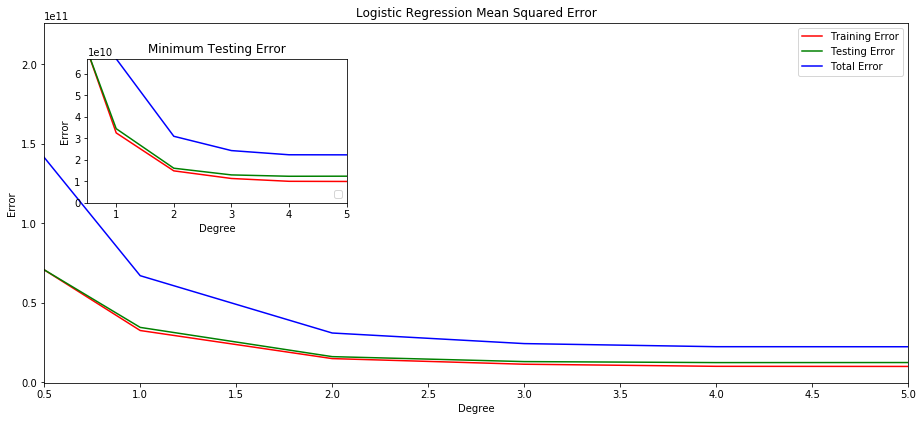

In [310]:
steps = np.arange(1,7,1)

tr_score = np.zeros(steps.shape)
tst_score = np.zeros(steps.shape)
trainErr = np.zeros(steps.shape)
testErr = np.zeros(steps.shape)

for i, step in enumerate(steps):
    # Generate polynomial features
    poly = PolynomialFeatures(step, interaction_only=True)
    pX_train = poly.fit_transform(X_train_new_subset)
    pX_test = poly.transform(X_test_new_subset)
    
    # Create model instance
    model = LogisticRegression()
    
    # Train model
    model.fit(pX_train, y_train_new_subset)
    
    # Make Predictions
    y_train_pred = model.predict(pX_train)
    y_test_pred = model.predict(pX_test)
    
    # Calculate Error and accuracy
    tr_score[i]=r2_score(y_train_new_subset, y_train_pred)
    tst_score[i]=r2_score(y_test_new_subset, y_test_pred)
    trainErr[i] = mean_squared_error(y_train_new_subset, y_train_pred)
    testErr[i] = mean_squared_error(y_test_new_subset, y_test_pred)
#print("Logistic Regression Average Accuracy Based on Bias-Variance Trade-off of Training Data:")
#print(tr_score)
#print("Logistic Regression Average Accuracy Based on Bias-Variance Trade-off of Test Data:")
#print(tst_score)
fig = plt.figure(figsize=(12,5))

totalErr = trainErr + testErr

axes1 = fig.add_axes([0, 0, 1, 1]) # main axes
axes2 = fig.add_axes([0.05, .5, .3, .4]) # inner axes

axes1.plot(trainErr,'r',label='Training Error')
axes1.plot(testErr,'g',label='Testing Error')
axes1.plot(totalErr, 'b', label='Total Error')

axes1.set_title("Logistic Regression Mean Squared Error")
axes1.set_xlabel("Degree")
axes1.set_ylabel("Error")
axes1.set_xlim(0.5,steps[-2])
axes1.legend(loc=1)

axes2.plot(trainErr,'r')
axes2.plot(testErr,'g')
axes2.plot(totalErr,'b')
axes2.set_xlim(0.5,steps[-2])
axes2.set_ylim(0, totalErr[1]+10)
axes2.set_title("Minimum Testing Error")
axes2.set_xlabel("Degree")
axes2.set_ylabel("Error")

plt.legend(loc=4)

In [314]:
print("Logistic Regression R2 Accuracy Based on Bias-Variance Trade-off of Training Data: %.2f%% " % (tr_score[5]*100.0))
print("Logistic Regression R2 Accuracy Based on Bias-Variance Trade-off of Testing Data: %.2f%% " % (tst_score[5]*100.0))

Logistic Regression R2 Accuracy Based on Bias-Variance Trade-off of Training Data: -180.92% 
Logistic Regression R2 Accuracy Based on Bias-Variance Trade-off of Testing Data: -278.43% 


In this model, testing error is always higher than training error and it means that our model is overfitted to our training error or in other words, we are experiencing high variance and low bias. Total error trend shows a decrease as the complexity increase but the accuracy of training and testing shows a negative accuracy which means that our model fits the data really poorly. In part 5 we can also see that without R2_scoring, the difference between training and testing accuracy is 55% that can prove logistic regression is not a good option for the present case.

#### D) SVM Bias-Variance Trade-off:

No handles with labels found to put in legend.


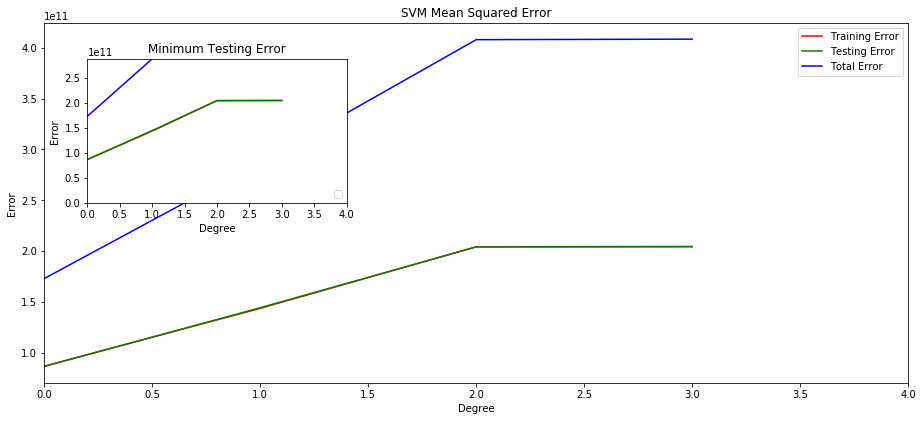

In [315]:
steps = np.arange(1,5,1)

tr_score = np.zeros(steps.shape)
tst_score = np.zeros(steps.shape)
trainErr = np.zeros(steps.shape)
testErr = np.zeros(steps.shape)

for i, step in enumerate(steps):
    # Generate polynomial features
    poly = PolynomialFeatures(step, interaction_only=True)
    pX_train = poly.fit_transform(X_train_new_subset)
    pX_test = poly.transform(X_test_new_subset)
    
    # Create model instance
    model = SVC(random_state=1,C=10)
    
    # Train model
    model.fit(pX_train, y_train_new_subset)
    
    # Make Predictions
    y_train_pred = model.predict(pX_train)
    y_test_pred = model.predict(pX_test)
    
    # Calculate Error and accuracy
    tr_score[i]=r2_score(y_train_new_subset, y_train_pred)
    tst_score[i]=r2_score(y_test_new_subset, y_test_pred)
    trainErr[i] = mean_squared_error(y_train_new_subset, y_train_pred)
    testErr[i] = mean_squared_error(y_test_new_subset, y_test_pred)
#print("Logistic Regression Average Accuracy Based on Bias-Variance Trade-off of Training Data:")
#print(tr_score)
#print("Logistic Regression Average Accuracy Based on Bias-Variance Trade-off of Test Data:")
#print(tst_score)
fig = plt.figure(figsize=(12,5))

totalErr = trainErr + testErr

axes1 = fig.add_axes([0, 0, 1, 1]) # main axes
axes2 = fig.add_axes([0.05, .5, .3, .4]) # inner axes

axes1.plot(trainErr,'r',label='Training Error')
axes1.plot(testErr,'g',label='Testing Error')
axes1.plot(totalErr, 'b', label='Total Error')

axes1.set_title("SVM Mean Squared Error")
axes1.set_xlabel("Degree")
axes1.set_ylabel("Error")
axes1.set_xlim(0,steps[-1])
axes1.legend(loc=1)

axes2.plot(trainErr,'r')
axes2.plot(testErr,'g')
axes2.plot(totalErr,'b')
axes2.set_xlim(0,steps[-1])
axes2.set_ylim(0, totalErr[1]+10)
axes2.set_title("Minimum Testing Error")
axes2.set_xlabel("Degree")
axes2.set_ylabel("Error")

plt.legend(loc=4)

In [316]:
print("SVM R2 Accuracy Based on Bias-Variance Trade-off of Training Data: %.2f%% " % (tr_score[1]*100.0))
print("SVM R2 Accuracy Based on Bias-Variance Trade-off of Testing Data: %.2f%% " % (tst_score[1]*100.0))

SVM R2 Accuracy Based on Bias-Variance Trade-off of Training Data: -3957.88% 
SVM R2 Accuracy Based on Bias-Variance Trade-off of Testing Data: -4302.46% 


Previous figure shows that training and testing error have the same amount during the time we increase the complexity of our model. This could be a good sign if the trend of our data didn't show an increase in total error. In this case, we can interpret the result as an example of a model which is highly overfitted to training data and con not be a good option for being our best model. The accuracy of this model also shows that this model fitted to our testing set really poorly.

If we want to select the best model based on bias-variance trade off, we should say that Linear Regression and KNN model can reach to their optimal bias-variance regression. Based on our bias-variance trade- off, If we want to make a comparison between total error of different models, we can see that Linear Regression has the least amount of total error in optimal bias variance trade-off point. Moreover, the comparison between cross validations and accuracy of each model which we hade done in the previous section also shows that Linear Regression has the highest accuracy. Thus, The best model is **Linear Regression** with regards to our results. 

### BONUS: Regularization Algorithms Bias-variance Trade-off

No handles with labels found to put in legend.


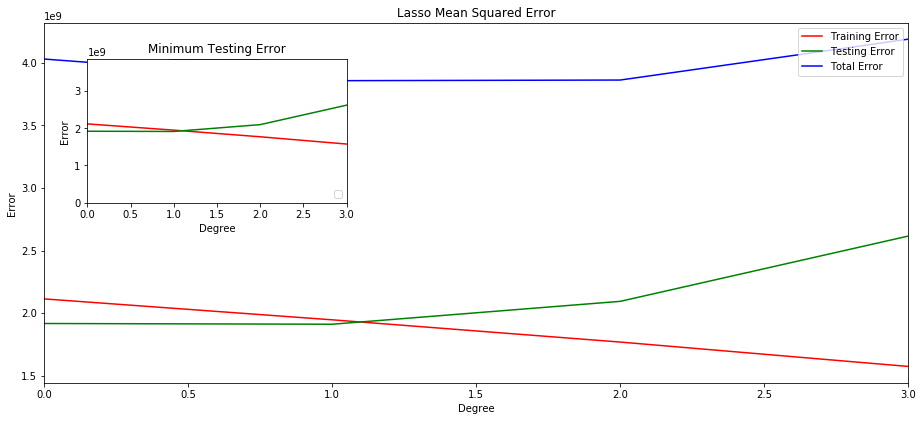

In [64]:
#Lasso
steps = np.arange(1,5,1)

tr_score = np.zeros(steps.shape)
tst_score = np.zeros(steps.shape)
trainErr = np.zeros(steps.shape)
testErr = np.zeros(steps.shape)

for i, step in enumerate(steps):
    # Generate polynomial features
    poly = PolynomialFeatures(step, interaction_only=True)
    pX_train = poly.fit_transform(X_train_new_subset)
    pX_test = poly.transform(X_test_new_subset)
    
    # Create model instance
    model = linear_model.Lasso(alpha = 1.0,max_iter=20000)
    
    # Train model
    model.fit(pX_train, y_train_new_subset)
    
    # Make Predictions
    y_train_pred = model.predict(pX_train)
    y_test_pred = model.predict(pX_test)
    
    # Calculate Error and accuracy
    tr_score[i]=r2_score(y_train_new_subset, y_train_pred)
    tst_score[i]=r2_score(y_test_new_subset, y_test_pred)
    trainErr[i] = mean_squared_error(y_train_new_subset, y_train_pred)
    testErr[i] = mean_squared_error(y_test_new_subset, y_test_pred)
#print("Lasso Average Accuracy Based on Bias-Variance Trade-off of Training Data:")
#print(tr_score)
#print("Lasso Average Accuracy Based on Bias-Variance Trade-off of Test Data:")
#print(tst_score)
fig = plt.figure(figsize=(12,5))

totalErr = trainErr + testErr

axes1 = fig.add_axes([0, 0, 1, 1]) # main axes
axes2 = fig.add_axes([0.05, .5, .3, .4]) # inner axes

axes1.plot(trainErr,'r',label='Training Error')
axes1.plot(testErr,'g',label='Testing Error')
axes1.plot(totalErr, 'b', label='Total Error')

axes1.set_title("Lasso Mean Squared Error")
axes1.set_xlabel("Degree")
axes1.set_ylabel("Error")
axes1.set_xlim(0,steps[-2])
axes1.legend(loc=1)

axes2.plot(trainErr,'r')
axes2.plot(testErr,'g')
axes2.plot(totalErr,'b')
axes2.set_xlim(0,steps[-2])
axes2.set_ylim(0, totalErr[1]+10)
axes2.set_title("Minimum Testing Error")
axes2.set_xlabel("Degree")
axes2.set_ylabel("Error")

plt.legend(loc=4)

Here Lasso Regularization with one degree has the lowest amount of total error. This figure shows that when our model become more complex, the testing error will increase and the model will become overfitted to our training set. In this case we are experiencing high variance and low bias.

No handles with labels found to put in legend.


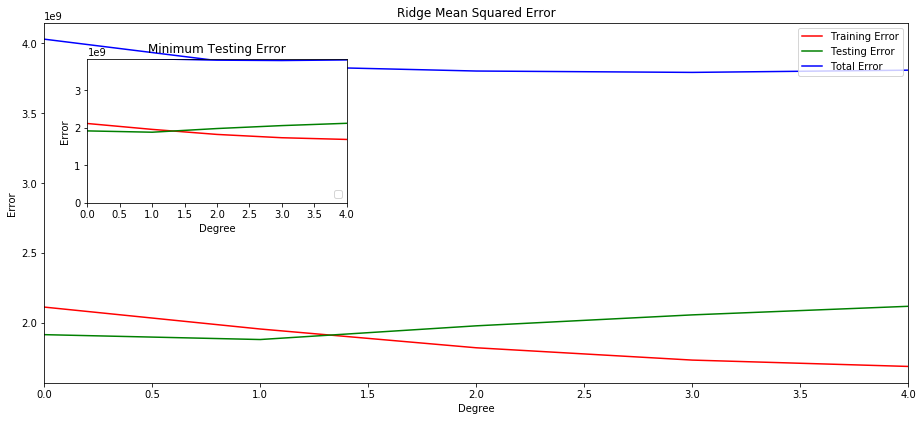

In [65]:
#Ridge
steps = np.arange(1,6,1)

tr_score = np.zeros(steps.shape)
tst_score = np.zeros(steps.shape)
trainErr = np.zeros(steps.shape)
testErr = np.zeros(steps.shape)

for i, step in enumerate(steps):
    # Generate polynomial features
    poly = PolynomialFeatures(step, interaction_only=True)
    pX_train = poly.fit_transform(X_train_new_subset)
    pX_test = poly.transform(X_test_new_subset)
    
    # Create model instance
    model = Ridge(alpha = 1.0,max_iter=20000)
    
    # Train model
    model.fit(pX_train, y_train_new_subset)
    
    # Make Predictions
    y_train_pred = model.predict(pX_train)
    y_test_pred = model.predict(pX_test)
    
    # Calculate Error and accuracy
    tr_score[i]=r2_score(y_train_new_subset, y_train_pred)
    tst_score[i]=r2_score(y_test_new_subset, y_test_pred)
    trainErr[i] = mean_squared_error(y_train_new_subset, y_train_pred)
    testErr[i] = mean_squared_error(y_test_new_subset, y_test_pred)
#print("Ridge Average Accuracy Based on Bias-Variance Trade-off of Training Data:")
#print(tr_score)
#print("Ridge Average Accuracy Based on Bias-Variance Trade-off of Test Data:")
#print(tst_score)
fig = plt.figure(figsize=(12,5))

totalErr = trainErr + testErr

axes1 = fig.add_axes([0, 0, 1, 1]) # main axes
axes2 = fig.add_axes([0.05, .5, .3, .4]) # inner axes

axes1.plot(trainErr,'r',label='Training Error')
axes1.plot(testErr,'g',label='Testing Error')
axes1.plot(totalErr, 'b', label='Total Error')

axes1.set_title("Ridge Mean Squared Error")
axes1.set_xlabel("Degree")
axes1.set_ylabel("Error")
axes1.set_xlim(0,steps[-2])
axes1.legend(loc=1)

axes2.plot(trainErr,'r')
axes2.plot(testErr,'g')
axes2.plot(totalErr,'b')
axes2.set_xlim(0,steps[-2])
axes2.set_ylim(0, totalErr[1]+10)
axes2.set_title("Minimum Testing Error")
axes2.set_xlabel("Degree")
axes2.set_ylabel("Error")

plt.legend(loc=4)

Here Ridge Regularization with one degree has the lowest amount of total error. This figure shows that when our model become more complex, the testing error will increase andthe model will become overfitted to our training set. In this case we are experiencing high variance and low bias.

In this section, we tried to analyze our models based on bias-variance trade-off. We found the correlation of bias with training error and the correlation of variance with testing error. whenever we experienced high testing error (high variance) and low training error ( low bias) the model will become over fitted to the training data or when we had low variance and high bias, we experienced underfitting.

Based on our disscussion for each model, we can notice that **Linear Regression** model is the best algorithm based on bias-variance trade-off. Best option after linear regression model is KNN.


# Part 5: Model Tuning

In this Part, we will improve performance of the models from the previous step with hyper parameter tuning usuing grid search based on R2 and RMSE metrics.

**Grid Search:**

Grid-searching is the process of scanning the data to configure optimal parameters for a given model. Depending on the type of model utilized, certain parameters are necessary. Grid-searching does NOT only apply to one model type. Grid-searching can be applied across machine learning to calculate the best parameters to use for any given model. It is important to note that Grid-searching can be extremely computationally expensive and may take your machine quite a long time to run. Grid-Search will build a model on each parameter combination possible. It iterates through every parameter combination and stores a model for each combination. Without further ado, lets jump into some examples and implementation.

Now, we will disscuss about metrics for avaluation of our mode. There are lots of these metrics but we should use these metrics for the right model. Based on liturature review, we should consider this categorization for choosing right metric:

![f](https://cdn-images-1.medium.com/max/1600/1*8VM2PELQ-oeM0O3ya7BIyQ.png)

**RMSE:**

It represents the sample standard deviation of the differences between predicted values and observed values (called residuals). Mathematically, it is calculated using this formula:

![h](https://cdn-images-1.medium.com/max/1600/1*pQR9id8CtnsdKljm8KODuw.png)

The difference between averraging (of absolute difference between the predicted values and observed value) and RMSE is that in averaging, all the individual differences weighted equally and it is a linear score. As far as RMSE will not equally weigh individal data, just in case all the differences are equal or zero, RMSE and averaging will be the same. In other words, averaging will directly takes the average of offsets whereas RMSE penelizes the higher difference more than averaging becasue of its formulation.

**R Squared:**

R2 squared will explain how well our selected independent variables explain the variability in our dependent variables. The formula for having R2 squared methos is like this:

![g](https://cdn-images-1.medium.com/max/1600/1*d7IVANCDovpXKP5N0rR2Yg.png)




#### A) KNN Hyperparameter Tuning:

In [66]:
knn = KNeighborsRegressor()

In [95]:
#%%time
#parameters = {'leaf_size': [30,50,70,90],'n_neighbors': [5,10,15,25]}            
#knn_best = GridSearchCV(knn,param_grid=parameters,cv=5,scoring='r2').fit(X_train_new_subset,y_train_new_subset)

Wall time: 27.4 s


In [97]:
#knn_best.best_estimator_
#print('leaf_size:',knn_best.best_estimator_.leaf_size)
#print('n_neighbors:',knn_best.best_estimator_.n_neighbors)

leaf_size: 70
n_neighbors: 15


In [67]:
knn_best_model = KNeighborsRegressor(leaf_size=70,n_neighbors=15).fit(X_train_new_subset,y_train_new_subset)
print("Tuned Model Accuracy of Training Data: %.2f%% " % (knn_best_model.score(X_train_new_subset,y_train_new_subset,sample_weight=None)*100.0))
print("Tuned Model Accuracy of Testing Data: %.2f%% " % (knn_best_model.score(X_test_new_subset, y_test_new_subset)*100.0))
print("Tuned Model RMSE of Testing Data:{}".format(np.sqrt(mean_squared_error(knn_best_model.predict(X_test_new_subset), y_test_new_subset))))

Tuned Model Accuracy of Training Data: 45.15% 
Tuned Model Accuracy of Testing Data: 38.83% 
Tuned Model RMSE of Testing Data:44744.60915012379


In comparison to KNN accuracy without hyperparameter tuning, accuracy of training data increased more than 11%.

#### B) Linear Regression Hyperparameter Tuning:

In [68]:
lr=LinearRegression()

In [70]:
#%%time
#parameters = {'normalize': [True,False],'fit_intercept': [True,False]}            
#lr_best = GridSearchCV(lr,param_grid=parameters,cv=5,scoring='r2').fit(X_train_new_subset,y_train_new_subset)

Wall time: 88.8 ms


In [107]:
#lr_best.best_estimator_
#print('normalize:',lr_best.best_estimator_.normalize)
#print('fit_intercept:',lr_best.best_estimator_.fit_intercept)

normalize: False
fit_intercept: True


In [71]:
lr_best_model = LinearRegression(normalize='False',fit_intercept='True').fit(X_train_new_subset,y_train_new_subset)
print("Tuned Model Accuracy of Training Data: %.2f%% " % (lr_best_model.score(X_train_new_subset,y_train_new_subset,sample_weight=None)*100.0))
print("Tuned Model Accuracy of Testing Data: %.2f%% " % (lr_best_model.score(X_test_new_subset, y_test_new_subset)*100.0))
print("Tuned Model RMSE of Testing Data:{}".format(np.sqrt(mean_squared_error(lr_best_model.predict(X_test_new_subset), y_test_new_subset))))

Tuned Model Accuracy of Training Data: 40.23% 
Tuned Model Accuracy of Testing Data: 41.43% 
Tuned Model RMSE of Testing Data:43782.0217047237


In comparison to Linear Regression accuracy without hyperparameter tuning, accuracy of training data increased 1%.

#### C) Logistic Regression Hyperparameter Tuning:

In [72]:
lor=LogisticRegression()

In [121]:
#%%time
#parameters = {'dual': [True,False],'C': [100,1000,10000]}            
#lor_best = GridSearchCV(lor,param_grid=parameters,cv=5,scoring='r2').fit(X_train_new_subset,y_train_new_subset)

d:\Users\rmardani\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 1h 20min 56s


In [122]:
#lor_best.best_estimator_
#print('dual:',lor_best.best_estimator_.dual)
#print('C:',lor_best.best_estimator_.C)

dual: True
C: 1000


In [75]:
lor_best_model =LogisticRegression(C=1000).fit(X_train_new_subset,y_train_new_subset)
print("Tuned Model Accuracy of Training Data: %.2f%% " % (lor_best_model.score(X_train_new_subset,y_train_new_subset,sample_weight=None)*100.0))
print("Tuned Model Accuracy of Testing Data: %.2f%% " % (lor_best_model.score(X_test_new_subset, y_test_new_subset)*100.0))
print("Tuned Model RMSE of Testing Data:{}".format(np.sqrt(mean_squared_error(lor_best_model.predict(X_test_new_subset), y_test_new_subset))))

Tuned Model Accuracy of Training Data: 89.07% 
Tuned Model Accuracy of Testing Data: 0.00% 
Tuned Model RMSE of Testing Data:78613.47440874172


In comparison to Logistic Regression accuracy without hyperparameter tuning, accuracy of training data decreased 9% but the testing accuracy is not good at all.

#### D) Decision Tree Hyperparameter Tuning:

In [76]:
dt=tree.DecisionTreeRegressor()

In [127]:
#%%time
#parameters = {'max_depth': [1,5,10],'min_samples_leaf': [1,2,3]}            
#dt_best = GridSearchCV(dt,param_grid=parameters,cv=5,scoring='r2').fit(X_train_new_subset,y_train_new_subset)

Wall time: 334 ms


In [128]:
#dt_best.best_estimator_
#print('max_depth:',dt_best.best_estimator_.max_depth)
#print('min_samples_leaf:',dt_best.best_estimator_.min_samples_leaf)

max_depth: 5
min_samples_leaf: 2


In [77]:
dt_best_model = tree.DecisionTreeRegressor(max_depth=5,min_samples_leaf=2).fit(X_train_new_subset,y_train_new_subset)
print("Tuned Model Accuracy of Training Data: %.2f%% " % (dt_best_model.score(X_train_new_subset,y_train_new_subset,sample_weight=None)*100.0))
print("Tuned Model Accuracy of Testing Data: %.2f%% " % (dt_best_model.score(X_test_new_subset, y_test_new_subset)*100.0))
print("Tuned Model RMSE of Testing Data:{}".format(np.sqrt(mean_squared_error(dt_best_model.predict(X_test_new_subset), y_test_new_subset))))

Tuned Model Accuracy of Training Data: 44.22% 
Tuned Model Accuracy of Testing Data: 40.02% 
Tuned Model RMSE of Testing Data:44309.10409530615


In comparison to Decision Tree accuracy without hyperparameter tuning, accuracy of training data increased 16% and there is not much difference between training and testing accuracy.

#### E) SVM Hyperparameter Tuning:

In [78]:
svm=SVC()

In [168]:
#%%time
#parameters = {'C': [100,1000],'max_iter': [1,3]}            
#svm_best = GridSearchCV(svm,param_grid=parameters,cv=5,scoring='r2').fit(X_train_new_subset,y_train_new_subset)

Wall time: 4h 58min 46s


In [172]:
#svm_best.best_estimator_
#print('max_iter:',svm_best.best_estimator_.max_iter)
#print('C:',svm_best.best_estimator_.C)

max_iter: 1
C: 1000


In [79]:
svm_best_model = SVC(max_iter=1, C=1000).fit(X_train_new_subset,y_train_new_subset)
print("Tuned Model Accuracy of Training Data: %.2f%% " % (svm_best_model.score(X_train_new_subset,y_train_new_subset,sample_weight=None)*100.0))
print("Tuned Model Accuracy of Testing Data: %.2f%% " % (svm_best_model.score(X_test_new_subset, y_test_new_subset)*100.0))
print("Tuned Model RMSE of Testing Data:{}".format(np.sqrt(mean_squared_error(svm_best_model.predict(X_test_new_subset), y_test_new_subset))))

Tuned Model Accuracy of Training Data: 89.21% 
Tuned Model Accuracy of Testing Data: 0.00% 
Tuned Model RMSE of Testing Data:57505.42429488476


In comparison to Decision Tree accuracy without hyperparameter tuning, accuracy of training data increased 49% but the testing accuracy shows that this high accuracy happend becasue of overfitting and this algorithm is not a good option for this dataset with this configuration.

#### BONUS: F) Gradient Boosting Regressor Hyperparameter Tuning:

GradientBoostingRegressor from sklearn is a popular and user-friendly application of Gradient Boosting in Python. Gradient boosting produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

Boosting is an ensemble technique in which the predictors are not made independently, but sequentially.
This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors. Therefore, the observations have an unequal probability of appearing in subsequent models and ones with the highest error appear most. (So the observations are not chosen based on the bootstrap process, but based on the error). The predictors can be chosen from a range of models like decision trees, regressors, classifiers etc. Because new predictors are learning from mistakes committed by previous predictors, it takes less time/iterations to reach close to actual predictions. But we have to choose the stopping criteria carefully or it could lead to overfitting on training data. Gradient Boosting is an example of boosting algorithm.

![a](https://cdn-images-1.medium.com/max/1000/1*PaXJ8HCYE9r2MgiZ32TQ2A.png)

In [80]:
model_example = GradientBoostingRegressor(random_state=1)

In [63]:
#%%time
#parameters = {'learning_rate': [0.01, 1],'max_depth': [1,10]}            
#model_best = GridSearchCV(model_example,param_grid=parameters,cv=10,scoring='neg_mean_absolute_error').fit(X_train_new,y_train_new)

Wall time: 1h 19min 7s


In [64]:
#model_best.best_estimator_
#print('learning_rate:',model_best.best_estimator_.learning_rate)
#print('Max_depth:',model_best.best_estimator_.max_depth)

learning_rate: 0.1
Max_depth: 5


With these 2 parameters of GradientBoostingRegressor we we can find the accuracy of best model: 

In [81]:
my_best_model = GradientBoostingRegressor(learning_rate=0.1,max_depth=5).fit(X_train_new_subset,y_train_new_subset)
print("Tuned Model Accuracy of Training Data: %.2f%% " % (my_best_model.score(X_train_new_subset,y_train_new_subset,sample_weight=None)*100.0))
print("Tuned Model Accuracy of Testing Data: %.2f%% " % (my_best_model.score(X_test_new_subset, y_test_new_subset)*100.0))
print("Tuned Model RMSE of Testing Data:{}".format(np.sqrt(mean_squared_error(my_best_model.predict(X_test_new_subset), y_test_new_subset))))

Tuned Model Accuracy of Training Data: 63.57% 
Tuned Model Accuracy of Testing Data: 41.50% 
Tuned Model RMSE of Testing Data:43756.99737838273


If we want to explain how this algorithm aapplies to the data, we should say that this algorithm at the first stage will use simple models to analyze the data for error. These errors are kind of hard for simple algorithms to model them but after handling data without error, it will focus on fitting the data which was not possible in the previous stage.

At the end, it will combine all the predictors by giving some weights to each predictor.

# Part 6: Testing & Discussion

Let's review what I have done during this project:

    Part1: I tried to use 3 main methods for dealing with missing values (filling missing values with 'N/A', droping rows or columns with many missing values, and filling missing values with mode of column) and then I encode data. For encoding, I used 2 methods; for nominal data which they don't have order, I used One Hot encoding and for those with order, I encoded them manually. After encoding, I performed scaling to set all labels between 0 and 1. In all these procedures, not droping too much data and not providing unreal data was my priority. 
    
    Part2: In this part, I tried to find a visual relation between yearly compensation and other variables like gender, education, job experience, etc. Based on these figures, I proposed trends of variables with regards to the target value (yearly compensation). In the end, by using correlation plots, I tried to find the features with higher importance.
    
    Part3: In this part, I used Random forrest method to find the features with high importance (I also tried RBF method for feature selection and the result was somehow similar to Random Forrest result). As far as I used scaling, I am sure that the effect of using 2 methods for encoding, will not make any bad effect on data. I extracted 165 features out of 350 and I used this 165 for next parts of this project.
    
    Part4: I used 5 regression methods (Linear Regression, Logistic Regression, KNN, SVM, and Decision Tree) on training data using 10-fold cross validation. High variation between folds accuracy cross validation showed that Logistic Regression and SVM are not a good option for predicting our target value. In other methods like KNN, Decision Tree, and Linear Reggression fold's accuracies are somehow close and Linear Regression performed better than others. After that, I explained bias-variance trade-off, underfitting, overfitting, and applied that in our past 5 regression methods. Based on the amount of error and bias-variance, I chosed Linear Regression algorithm as the best one which is not overfitted or underfitted. 
    
    Part5: In this part, I tried to optimize the performance of thoe 5 regression algorithms which I used in part4. For achieving this goal, I performed hyper parameter tuning and GridSearch based on different metrics. Ourfinal results shows that the accuracy of our best model (Linear Regression) increased 1% on training set and the accuracy of test set increased 3%.
    
I used optimal model for making predictions on the test set and here is the summary of each one:

    1- KNN: Training Accuracy: 45.15%          Testing Accuracy: 38.83%          Slightly Overfitted
    
    2- Linear Regression: Training Accuracy: 40.23%          Testing Accuracy: 41.43%         Not Overfitted nor Underfitted
    
    3- Logistic Regression: Training Accuracy: 54.88%          Testing Accuracy: 0%          Highly Overfitted
    
    4- Decision Tree: Training Accuracy: 44.22%          Testing Accuracy: 40.02%          Slightly Overfitted
    
    5- SVM: Training Accuracy: 89.21%          Testing Accuracy: 0%          Highly Overfitted

I chose Linear Regression as the best model for these reasons:

    • computationaly efficient
    
    • low difference between testing and training accuracies
    
    • optimal bias-variance trade-off
    
    • uniform distribution of accuracy between folds of cross validation
    
The second and third best algorithms are Decision Tree and KNN and the  only preference for choosing Linear regression is not being overfitted at all and it could perform better in all sections of cross validation and bias-variance trade-off.

# Part 7: BONUS

In this part, I will implement a neural network to predict the target variable with different neural network architectures and parameters. 

Before that, if we want to consider NN method for data analysis, we should choose this model wisely with knowing its pros and cons. In the following, there are some pros and cons of this method:

Pros:

    • Neural networks are flexible and can be used for both regression and classification problems. Any data which can be made numeric can be used in the model, as neural network is a mathematical model with approximation functions.
 
    • Neural networks are good to model with nonlinear data with large number of inputs; for example, images. It is reliable in an approach of tasks involving many features. It works by splitting the problem of classification into a layered network of simpler elements.

    • Once trained, the predictions are pretty fast.

    • Neural networks can be trained with any number of inputs and layers.

    • Neural networks work best with more data points.

Cons:

    • Neural networks are black boxes, meaning we cannot know how much each independent variable is influencing the dependent variables.
    • It is computationally very expensive and time consuming to train with traditional CPUs.
    • Neural networks depend a lot on training data. This leads to the problem of over-fitting and generalization. The mode relies more on the training data and may be tuned to the data.


If I use NN algorithm with default setting, the accuracy for both training and testing would be zero. Thus, we need a few parameters to help MLPRRegressor to perform better. With the following setup, we can achieve accuracy of 42% for both training and test set which is acceptable. I will use this setup for exploring other architectures and parameters of NN algorithm.

In [82]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,6,6), random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 42.71% 
Neural Network  Accuracy of Test Data: 42.83% 


This model is considered as the base model.

**Architecture of different NN Solvers:**

There are three solvers available for NN method. Lets see what will happen if we use ‘sgd’ and ‘adam’.

In [83]:
mlp = MLPRegressor(solver='sgd', alpha=1e-5, hidden_layer_sizes=(6,6,6), random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: -71330725981544071505066374518737038370023010443313660540485766217728.00% 
Neural Network  Accuracy of Test Data: -77061400077322862597724448334107071011196609666533496671095870193664.00% 


‘sgd’ refers to stochastic gradient descent and don't perform good in our dataset.

In [84]:
mlp = MLPRegressor(solver='adam', alpha=1e-5, hidden_layer_sizes=(6,6,6), random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 41.40% 
Neural Network  Accuracy of Test Data: 42.45% 


‘adam’ refers to a stochastic gradient-based optimizer and perform as good as 'ibfgs' in our dataset.

If we want to make a comparison between these 3, 'ibfgs' (an optimizer in the family of quasi-Newton methods) is the best one.

**Architecture of different NN Learning rates:**
    
There are three learning rates available for NN method. Lets see what will happen if we use ‘invscaling’ and ‘adaptive’.

In [85]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,6,6),learning_rate='adaptive', random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 42.71% 
Neural Network  Accuracy of Test Data: 42.83% 


‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if ‘early_stopping’ is on, the current learning rate is divided by 5.

In [86]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,6,6),learning_rate='invscaling', random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 42.71% 
Neural Network  Accuracy of Test Data: 42.83% 


‘invscaling’ gradually decreases the learning rate learning_rate_ at each time step ‘t’ using an inverse scaling exponent of ‘power_t’. effective_learning_rate = learning_rate_init / pow(t, power_t)

These results show that changing learning rate, will not change accuracy of training and test sets.

**Architecture of different NN Maximum Iteration:**
    
Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations. For stochastic solvers (‘sgd’, ‘adam’), this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

In [87]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,6,6), random_state=1, max_iter=100)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 42.59% 
Neural Network  Accuracy of Test Data: 42.49% 


In [88]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,6,6), random_state=1, max_iter=10)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 4.31% 
Neural Network  Accuracy of Test Data: 4.42% 


As it is showing in 2 last part of code, decreasing maximum iteration will decrease the accuracy of our model.

In [89]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,6,6), random_state=1, max_iter=10000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 42.71% 
Neural Network  Accuracy of Test Data: 42.83% 


In [90]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,6,6), random_state=1, max_iter=100000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 42.71% 
Neural Network  Accuracy of Test Data: 42.83% 


Maximum iteration of 10000 is the maximum number which can have a positive impact on our accurecies. Every number higher than 10000 just increase the computation time of our model.

**Architecture of different NN Nodes:**

Let's see what will happen if we change the number of nodes in each layer:

In [91]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,15,6), random_state=1, max_iter=100000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 45.38% 
Neural Network  Accuracy of Test Data: 42.25% 


In [92]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,20,6), random_state=1, max_iter=100000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 42.34% 
Neural Network  Accuracy of Test Data: 42.82% 


The last two section of code shows that increasing number of nodes in a layer can increase the accuracy of training data or in other words it can make our model more overfitted to the training data. It should be noted that there is a threshold for increasing this parameter; after reaching this threshold, the accuracies will not change substantially.

In [93]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,3,6), random_state=1, max_iter=100000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 0.00% 
Neural Network  Accuracy of Test Data: -0.00% 


Decreasing number of nodes in each layer will reduce the accuracies substantially.

In [94]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,15,20), random_state=1, max_iter=10000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 42.99% 
Neural Network  Accuracy of Test Data: 42.91% 


Increasing the number of nodes in another direction increased the accuracy both in training and testing set slightly.

**Architecture of different NN Momentum:**

Let's see what will happen if we change Momentum:

In [95]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,15,20),momentum=0.999, random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 42.99% 
Neural Network  Accuracy of Test Data: 42.91% 


In [96]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,15,20),momentum=0.3, random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 42.99% 
Neural Network  Accuracy of Test Data: 42.91% 


As I expected, the momentum will not change the accuracies becasue momentum is a valid parameter when our solver is 'sgd'.

**Architecture of different NN Activation:**

Let's see what will happen if we change Momentum:

Activation function for the hidden layer.

‘identity’, no-op activation, useful to implement linear bottleneck, returns f(x) = x.

‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).

‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x).

‘relu’, the rectified linear unit function, returns f(x) = max(0, x) (default)

In [97]:
mlp = MLPRegressor(activation='logistic',solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,15,20), random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 0.00% 
Neural Network  Accuracy of Test Data: -0.00% 


In [98]:
mlp = MLPRegressor(activation='logistic',solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,15,20), random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 0.00% 
Neural Network  Accuracy of Test Data: -0.00% 


In [99]:
mlp = MLPRegressor(activation='tanh',solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,15,20), random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: -0.00% 
Neural Network  Accuracy of Test Data: -0.00% 


In [100]:
mlp = MLPRegressor(activation='identity',solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,15,20), random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 40.23% 
Neural Network  Accuracy of Test Data: 41.44% 


It shows that changing actication will not improve NN performance.

This is the last version of improved performance Neural Network model. What we have done here is similar to what GridSearch do for finding a tuned version of models. This is the final improved model of neural network:

In [101]:
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,15,20), random_state=1, max_iter=1000)  
mlp.fit(X_train_new_subset, y_train_new_subset) 
print("Neural Network  Accuracy of Training Data: %.2f%% " % (mlp.score(X_train_new_subset, y_train_new_subset)*100.0))
print("Neural Network  Accuracy of Test Data: %.2f%% " % (mlp.score(X_test_new_subset, y_test_new_subset)*100.0))

Neural Network  Accuracy of Training Data: 42.99% 
Neural Network  Accuracy of Test Data: 42.91% 


In comparison with our best optimal model in part 5, this model shows 3% higher accuracy in training and testing sets.

# References:

https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/
    
https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff
    
https://gerardnico.com/data_mining/bias_trade-off

https://medium.com/diogo-menezes-borges/whats-the-trade-off-between-bias-and-variance-c05b241b15d9

https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4

https://medium.com/@elutins/grid-searching-in-machine-learning-quick-explanation-and-python-implementation-550552200596

https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788397872/1/ch01lvl1sec27/pros-and-cons-of-neural-networks
    
Scikit Learn Documentations